In [1]:
import os
import math

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear

import torch_geometric as tg
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import CGConv
from torch_geometric.nn.aggr import AttentionalAggregation

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, PredefinedSplit
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from rdkit import Chem

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append(os.getcwd())

from src.load_utils import *
from src.feature_importance import *

# Hyperparameters/Target Labels

In [3]:
# Labels/Hyperparameter definition

target_cols_labels_full = [
    "CONDUCTIVITY",
    "TFSI Diffusivity",
    "Li Diffusivity",
    "Poly Diffusivity",
    "Transference Number",
]

csv_path = 'data/temp_full_data.csv'

# Initial Training Parameters
batch_size = 256
num_epochs = 200

# Hidden layer parameters
fea_dim  = 96
n_layers = 4
n_hidden = 2

# Adam optimizer hyperparameters
learning_rate = 1e-4
weight_decay  = 1e-6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = "model_out"
os.makedirs(save_dir, exist_ok=True)

MAE_MULT = 2
N_OPT_ITER = 10

# Function definition for data processing

In [4]:
# Setup feature ranges based on SMILES strings

def compute_feature_ranges(list_of_smiles):
    # node/atom features
    atom_symbols   = set()
    degrees        = set()
    formal_charges = set()
    num_hs         = set()
    hybridizations = set()
    
    # edge/bond features
    bond_types   = set()
    bond_stereo  = set()
    conjugations = set()

    for smile in list_of_smiles:
        mol = Chem.MolFromSmiles(smile)
        if mol is None:
            continue # only process valid SMILES strings

        for atom in mol.GetAtoms():
            # add relevant atom features
            atom_symbols.add(atom.GetSymbol())
            degrees.add(atom.GetDegree())
            formal_charges.add(atom.GetFormalCharge())
            num_hs.add(atom.GetTotalNumHs())
            hybridizations.add(str(atom.GetHybridization()))

        for bond in mol.GetBonds():
            # add relevant bond features
            bond_types.add(str(bond.GetBondType()))
            bond_stereo.add(str(bond.GetStereo()))
            conjugations.add(bond.GetIsConjugated())
    
    x_map = {
        "atomic_symbol": sorted(atom_symbols),
        "degree": sorted(degrees),
        "formal_charge": sorted(formal_charges),
        "num_hs": sorted(num_hs),
        "hybridization": sorted(hybridizations),
        "is_aromatic": [False, True],
        "is_in_ring": [False, True],
    }

    e_map = {
        "bond_type": sorted(bond_types),
        "stereo": sorted(bond_stereo),
        "is_conjugated": [False, True],
    }

    return x_map, e_map # feature ranges will be based off of entire dataset

def add_unknowns(x_map: dict, e_map: dict): # in case of unseens feature categories
    # Add UNK token to categorical lists if not present
    for k in ["atomic_symbol", "hybridization"]:
        if "UNK" not in x_map[k]:
            x_map[k].append("UNK")
            
    # For degree/formal_charge/num_hs: we will keep them as discrete sets but
    # if unseen values appear we will map to a min/max or UNK index — we append 'UNK' as str to be safe.
    for k in ["degree", "formal_charge", "num_hs"]:
        if "UNK" not in x_map[k]:
            x_map[k] = list(x_map[k]) + ["UNK"]

    for k in ["bond_type", "stereo"]:
        if "UNK" not in e_map[k]:
            e_map[k].append("UNK")

    # ensure boolean lists contain False/True, 0/1
    x_map['is_aromatic'] = [False, True]
    x_map['is_in_ring'] = [False, True]
    e_map['is_conjugated'] = [False, True]

    return x_map, e_map

def get_bond_feature_dim(e_map):
    dim = (
        len(e_map["bond_type"]) +
        len(e_map["stereo"]) +
        len(e_map["is_conjugated"])
    )
    return dim

In [5]:
# Feature Definition: one-hot, atom (node), bond (edge), generate graph from SMILES

def one_hot(x, choices):
    if x not in choices:
        x = "UNK"
    return np.array([x == c for c in choices], dtype=float)

def atom_features(atom, x_map):
    symbol   = atom.GetSymbol()
    degree   = atom.GetDegree()
    fc       = atom.GetFormalCharge()
    hs       = atom.GetTotalNumHs()
    hyb      = str(atom.GetHybridization())
    aromatic = atom.GetIsAromatic()
    ring     = atom.IsInRing()

    return np.concatenate([
        one_hot(symbol, x_map["atomic_symbol"]),
        one_hot(degree, x_map["degree"]),
        one_hot(fc, x_map["formal_charge"]),
        one_hot(hs, x_map["num_hs"]),
        one_hot(hyb, x_map["hybridization"]),
        one_hot(aromatic, x_map["is_aromatic"]),
        one_hot(ring, x_map["is_in_ring"]),
    ])


def bond_features(bond, e_map):
    btype  = str(bond.GetBondType())
    stereo = str(bond.GetStereo())
    conj   = bond.GetIsConjugated()

    return np.concatenate([
        one_hot(btype, e_map["bond_type"]),
        one_hot(stereo, e_map["stereo"]),
        one_hot(conj, e_map["is_conjugated"]),
    ])

def smiles_to_graph(smiles, x_map, e_map, add_h: bool = True, add_self_loops=True):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")
    
    if add_h:
        mol = Chem.AddHs(mol)
    
    atom_feats = []
    edge_index = []
    edge_feats = []

    # Atom features
    for atom in mol.GetAtoms():
        atom_feats.append(atom_features(atom, x_map))

    # Bond features
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        bf = bond_features(bond, e_map)
        edge_index.append([i, j])
        edge_feats.append(bf)

        edge_index.append([j, i])
        edge_feats.append(bf)

    if add_self_loops: # self "bond"
        bond_dim = (
            len(e_map["bond_type"]) +
            len(e_map["stereo"]) +
            len(e_map["is_conjugated"])
        )
        zero_bond = np.zeros(bond_dim, dtype=float)
        
        num_atoms = len(atom_feats)
        for i in range(num_atoms):
            edge_index.append([i, i])
            edge_feats.append(zero_bond)

    x = torch.tensor(np.array(atom_feats), dtype=torch.float)
    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.long)
    edge_attr = torch.tensor(np.array(edge_feats), dtype=torch.float)
    
    g = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    g.num_nodes = x.size(0)
    
    return g # uniquely shaped graph for each SMILES

In [6]:
# Process CSV file, generate graphs

class PolymerCSV(InMemoryDataset):
    def __init__(self, csv_path: str, target_cols: list[str], x_map: dict, e_map: dict, add_h: bool = True):
        super().__init__(None)
        self.df = pd.read_csv(csv_path)
        self.target_cols = target_cols
        
        self.x_map = x_map
        self.e_map = e_map
        self.add_h = add_h

        data_list = []
        for _, row in self.df.iterrows():
            smi = row.get("Mol_smiles_clean")
            if pd.isna(smi):
                continue

            try:
                g = smiles_to_graph(smi, self.x_map, self.e_map, self.add_h, True)
            except Exception as e:
                print(f"[Warning] Skipping SMILES {smi}: {e}")
                continue

            # collect targets and mask
            y = []
            mask = []
            for c in self.target_cols:
                val = row.get(c, np.nan) # get column value or NaN if unavailable
                if pd.isna(val):
                    y.append(0.0)
                    mask.append(0.0)
                else:
                    y.append(float(val))
                    mask.append(1.0)

            g.y = torch.tensor([y], dtype=torch.float)
            g.y_mask = torch.tensor([mask], dtype=torch.float)
            
            # optional: save trajectory id as meta
            if "Trajectory ID" in row:
                g.traj_id = int(row["Trajectory ID"])
                
            data_list.append(g)

        self.data, self.slices = self.collate(data_list)

# Convolutional Neural Network Setup

In [7]:
# Multitask CGCNN setup

class MultiTaskCGCNN(nn.Module):
    def __init__(self, node_in: int, edge_in: int, fea_dim=96, n_layers=4, n_hidden=2, out_dim=5, include_mol_features=False, mol_dim=0):
        super().__init__()
        self.node_embed = Linear(node_in, fea_dim)
        self.edge_embed = Linear(edge_in, fea_dim)
        self.include_mol_features = include_mol_features
        self.mol_dim = mol_dim

        self.convs = nn.ModuleList([
            CGConv(channels=fea_dim, dim=fea_dim, aggr="mean", batch_norm=True)
            for _ in range(n_layers)
        ])

        self.pool = AttentionalAggregation(
            gate_nn=Sequential(Linear(fea_dim, fea_dim), Linear(fea_dim, 1)),
            nn=Sequential(Linear(fea_dim, fea_dim), Linear(fea_dim, fea_dim))
        )

        if self.include_mol_features:
            if self.mol_dim == 0:
                raise ValueError("Must supply number of molecular features (>0)")
            
            fea_dim += self.mol_dim

        self.hiddens = nn.ModuleList([Linear(fea_dim, fea_dim) for _ in range(n_hidden)])
        self.head = Linear(fea_dim, out_dim)

    def forward(self, data: tuple[Data, torch.Tensor]):
        graph_data, mol_data = data
        x = F.leaky_relu(self.node_embed(graph_data.x)) # leaky ReLU for activation
        e = F.leaky_relu(self.edge_embed(graph_data.edge_attr)) # nodes and edges
        
        for conv in self.convs: # convolutional layers
            x = conv(x, graph_data.edge_index, e)
        
        g = self.pool(x, graph_data.batch) # pool after n_layers
        if self.include_mol_features: # concatenate pooled graph data with molecular data (optional)
            g = torch.cat((g, mol_data), dim=1)
        
        for h in self.hiddens: # pass through n_hidden layers
            g = F.leaky_relu(h(g))

        out = self.head(g) # outputs vector predicting desired properties
        return out

In [8]:
# Masked MSE & MAE

def masked_mse_loss(pred: torch.Tensor, y: torch.Tensor, mask: torch.Tensor):
    # pred,y,mask -> [B, T]
    
    diff = (pred - y) * mask
    denom = mask.sum()
    if denom.item() == 0:
        return torch.tensor(0.0, device=pred.device, requires_grad=True)
    
    return (diff * diff).sum() / denom


def masked_mae(pred: np.ndarray, y: np.ndarray, mask: np.ndarray):
    # numpy arrays
    diff = np.abs(pred - y) * mask
    denom = mask.sum()
    if denom == 0:
        return 0.0
    
    return diff.sum() / denom

In [9]:
# Train and evaluate epochs

def train_epoch(model, loader, optimizer, scaler: StandardScaler, device):
    model.train()
    total_loss = 0.0
    for batch1, batch2 in loader: # batch1 = graph data, batch2 = molecular data
        batch1 = batch1.to(device)
        batch2 = batch2.to(device)
        # scale batch targets using scaler trained on train set only
        y_cpu = batch1.y.cpu().numpy()
        y_scaled = torch.tensor(scaler.transform(y_cpu), dtype=torch.float, device=device)

        optimizer.zero_grad()
        out = model((batch1, batch2))
        loss = masked_mse_loss(out, y_scaled, batch1.y_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch1.num_graphs # collect loss from each graph
    
    loss = total_loss / len(loader.dataset)
    return loss


def eval_epoch(model, loader, scaler: StandardScaler, device):
    model.eval()
    total_loss = 0.0

    all_preds = []
    all_preds_scaled = []
    all_ys = []
    all_ys_scaled = []
    all_masks = []

    with torch.no_grad(): # evaluation should not update model
        for batch1, batch2 in loader:
            batch1 = batch1.to(device)
            batch2 = batch2.to(device)

            y_cpu = batch1.y.cpu().numpy()
            y_scaled_np = scaler.transform(y_cpu)
            y_scaled = torch.tensor(y_scaled_np, dtype=torch.float, device=device)

            out_scaled = model((batch1, batch2))
            out_scaled_np = out_scaled.cpu().numpy()

            loss = masked_mse_loss(out_scaled, y_scaled, batch1.y_mask)
            total_loss += loss.item() * batch1.num_graphs

            out_unscaled = scaler.inverse_transform(out_scaled.cpu().numpy())

            all_preds.append(out_unscaled)
            all_preds_scaled.append(out_scaled_np)
            all_ys.append(y_cpu)
            all_ys_scaled.append(y_scaled_np)

            all_masks.append(batch1.y_mask.cpu().numpy())

    if len(all_preds) == 0:
        return total_loss / max(1, len(loader.dataset)), None

    preds = np.vstack(all_preds)
    preds_scaled = np.vstack(all_preds_scaled)
    ys = np.vstack(all_ys)
    ys_scaled = np.vstack(all_ys_scaled)
    masks = np.vstack(all_masks)


    # per task loss/MAE
    T = preds.shape[1]
    per_task_mae = []
    per_task_r2 = []

    for t in range(T):
        mask_t = masks[:, t].astype(bool)

        if mask_t.sum() == 0:
            per_task_mae.append(None)
            per_task_r2.append(None)
            continue

        pred_t = preds_scaled[:, t][mask_t]
        y_t = ys_scaled[:, t][mask_t]

        mae_t = np.mean(np.abs(pred_t - y_t))
        per_task_mae.append(mae_t)

        if len(y_t) > 1:
            per_task_r2.append(r2_score(y_t, pred_t))
        else:
            per_task_r2.append(None)
            
    # compute global loss/MAE across all tasks using masking
    overall_loss = total_loss / len(loader.dataset)
    overall_mae = masked_mae(preds_scaled, ys_scaled, masks)
    overall_r2 = np.mean(per_task_r2)

    return overall_loss, overall_mae, overall_r2, per_task_mae, per_task_r2, preds, ys, masks

In [10]:
# Create training, validation, testing splits

def create_splits(df: pd.DataFrame, frac_train=0.8, frac_val=0.125):
    n = len(df)
    test_size = 1.0 - frac_train
    idx = np.arange(n)
    train_idx, test_idx = train_test_split(idx, test_size=test_size)
    train_idx, val_idx = train_test_split(train_idx, test_size=frac_val * frac_train)

    return train_idx.tolist(), val_idx.tolist(), test_idx.tolist()

In [11]:
### Build, train, and test model
def model_execution(
    csv_path=csv_path,
    target_cols=target_cols_labels_full,
    include_mol_features=False,
    batch_size=batch_size,
    num_epochs=num_epochs,
    fea_dim=fea_dim,
    n_layers=n_layers,
    n_hidden=n_hidden,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    return_predictions=False,
    verbose=0
):
    if isinstance(target_cols, str):
        target_cols = [target_cols]

    # Load CSV + build feature maps
    df = clean_dataframe(pd.read_csv(csv_path), method=OutlierType.Z_SCORE, cutoff=5, verbose=False)
    smiles_list = df["Mol_smiles_clean"].dropna().astype(str).tolist()

    mol_cols = [
        c for c in df.columns if c not in [*target_cols_labels_full, "Mol_smiles_clean", 'Unnamed: 0']
    ]
    mol_data = torch.tensor(df[mol_cols].values, dtype=torch.float32)

    x_map, e_map = compute_feature_ranges(smiles_list)
    x_map, e_map = add_unknowns(x_map, e_map)

    # Train/val/test splits
    train_idx, val_idx, test_idx = create_splits(df, frac_train=0.8, frac_val=0.125)

    dataset = PolymerCSV(csv_path, target_cols, x_map=x_map, e_map=e_map, add_h=True)

    train_ds = torch.utils.data.Subset(dataset, train_idx)
    val_ds   = torch.utils.data.Subset(dataset, val_idx)
    test_ds  = torch.utils.data.Subset(dataset, test_idx)
    
    train_mol_ds = torch.utils.data.Subset(mol_data, train_idx)
    val_mol_ds   = torch.utils.data.Subset(mol_data, val_idx)
    test_mol_ds  = torch.utils.data.Subset(mol_data, test_idx)

    train_loader = DataLoader([(d, v) for d, v in zip(train_ds, train_mol_ds)], batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader([(d, v) for d, v in zip(val_ds, val_mol_ds)],     batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader([(d, v) for d, v in zip(test_ds, test_mol_ds)],   batch_size=batch_size, shuffle=False)

    # Fit scaler only on training targets
    def collect_targets(subset):
        Ys = [g.y.numpy() for g in subset]
        return np.vstack(Ys) if Ys else np.zeros((0, len(target_cols)))

    y_train = collect_targets(train_ds)
    if y_train.shape[0] == 0:
        raise RuntimeError("No training examples with targets found!")

    scaler = StandardScaler()
    scaler.fit(y_train)

    if verbose:
        print(f"Found {len(smiles_list)} SMILES in CSV.")
        print("\n ===> Atom feature map sizes <===")
        for k, v in x_map.items():
            print(f"{k:>15}: {len(v)}")

        print("\n ===> Edge feature map sizes <===")
        for k, v in e_map.items():
            print(f"{k:>15}: {len(v)}")

        print(f"\nSplit sizes:\n   Training = {len(train_idx)}\n   Validation = {len(val_idx)}\n   Testing = {len(test_idx)}")
        print(f"\nTotal graphs built: {len(dataset)}")

    # Build model + optimizer
    sample = dataset[0]
    node_in = sample.x.shape[1]
    edge_in = sample.edge_attr.shape[1]
    out_dim = len(target_cols)
    mol_dim = len(mol_cols)

    model = MultiTaskCGCNN(
        node_in=node_in,
        edge_in=edge_in,
        fea_dim=fea_dim,
        n_layers=n_layers,
        n_hidden=n_hidden,
        out_dim=out_dim,
        include_mol_features=include_mol_features,
        mol_dim=mol_dim
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    best_val = float("inf")

    if include_mol_features:
        model_state_name = 'naive_model_nomol'
    else:
        model_state_name = 'naive_model_withmol'

    best_path = os.path.join(save_dir, f"{model_state_name}.pth")

    # Unified metrics structure
    metrics = {
        "train": {
            "loss": [],
            "mae":  [],
            "r2":   [],
            "per_task_mae": {t: [] for t in target_cols},
            "per_task_r2":  {t: [] for t in target_cols},
        },
        "val": {
            "loss": [],
            "mae":  [],
            "r2":   [],
            "per_task_mae": {t: [] for t in target_cols},
            "per_task_r2":  {t: [] for t in target_cols},
        },
        "test": {
            "loss": None,
            "mae":  None,
            "r2":   None,
            "per_task_mae": {t: None for t in target_cols},
            "per_task_r2":  {t: None for t in target_cols},
        }
    }


    # Training loop
    for epoch in tqdm(range(1, num_epochs + 1)):

        # training
        train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
        tr_loss, tr_mae, tr_r2, tr_pt_mae, tr_pt_r2, _, _, _ = eval_epoch(
            model, train_loader, scaler, device
        )
        tr_loss = train_loss   # override with actual loss from train_epoch

        # validation
        val_loss, val_mae, val_r2, val_pt_mae, val_pt_r2, _, _, _ = eval_epoch(
        model, val_loader, scaler, device
    )

        # store metrics
        metrics["train"]["loss"].append(tr_loss)
        metrics["train"]["mae"].append(tr_mae)
        metrics["train"]["r2"].append(tr_r2)

        metrics["val"]["loss"].append(val_loss)
        metrics["val"]["mae"].append(val_mae)
        metrics["val"]["r2"].append(val_r2)

        for i, t in enumerate(target_cols):
            metrics["train"]["per_task_mae"][t].append(tr_pt_mae[i])
            metrics["train"]["per_task_r2"][t].append(tr_pt_r2[i])
            metrics["val"]["per_task_mae"][t].append(val_pt_mae[i])
            metrics["val"]["per_task_r2"][t].append(val_pt_r2[i])

        # checkpoint
        if val_loss < best_val:
            best_val = val_loss
            torch.save(
                {
                    "model_state": model.state_dict(),
                    "scaler": scaler,
                    "x_map": x_map,
                    "e_map": e_map,
                    "metrics": metrics,
                },
                best_path,
            )

    # Final test evaluation
    ckpt = torch.load(best_path, map_location=device, weights_only=False)

    model.load_state_dict(ckpt["model_state"])
    scaler = ckpt["scaler"]

    test_loss, test_mae, test_r2, test_pt_mae, test_pt_r2, test_preds, test_ys, test_masks = eval_epoch(
        model, test_loader, scaler, device
    )

    metrics["test"]["loss"] = test_loss
    metrics["test"]["mae"]  = test_mae
    metrics["test"]["r2"]   = test_r2
    for i, t in enumerate(target_cols):
        metrics["test"]["per_task_mae"][t] = test_pt_mae[i]
        metrics["test"]["per_task_r2"][t]  = test_pt_r2[i]

    if return_predictions:
        return model, metrics, scaler, test_preds, test_ys, test_masks
    else:
        return model, metrics, scaler

In [12]:
# Plot metrics for final model
def plot_all_metrics(metrics, target_cols, save_prefix=None):

    target_col_str = False
    if isinstance(target_cols, str):
        target_cols = [target_cols]
        target_col_str = True

    epochs = np.arange(1, len(metrics["train"]["loss"]) + 1)
    fig_global, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

    # GLOBAL LOSS
    ax1.grid(True)
    ax1.plot(epochs, metrics["train"]["loss"], label="Train Loss")
    ax1.plot(epochs, metrics["val"]["loss"],   label="Val Loss")
    ax1.scatter([epochs[-1]], [metrics["test"]["loss"]], color="red", label="Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Scaled MSE Loss")
    if target_col_str:
        ax1.set_title(f'{target_cols[0]} Scaled Loss')
    else:
        ax1.set_title("Global Scaled Loss")
    ax1.legend()

    # GLOBAL MAE
    ax2.grid(True)
    ax2.plot(epochs, metrics["train"]["mae"], label="Train MAE")
    ax2.plot(epochs, metrics["val"]["mae"],   label="Val MAE")
    ax2.scatter([epochs[-1]], [metrics["test"]["mae"]], color="red", label="Test MAE")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Scaled MAE")
    if target_col_str:
        ax2.set_title(f'{target_cols[0]} Scaled MAE')
    else:
        ax2.set_title("Global Scaled MAE")
    ax2.legend()

    # GLOBAL R2
    ax3.grid(True)
    ax3.plot(epochs, metrics["train"]["r2"], label="Train R2")
    ax3.plot(epochs, metrics["val"]["r2"],   label="Val R2")
    ax3.scatter([epochs[-1]], [metrics["test"]["r2"]], color="red", label="Test R2")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("R2 Score")
    if target_col_str:
        ax3.set_title(f'{target_cols[0]} R2 Score')
    else:
        ax3.set_title("Global R2 Score")
    ax3.set_ylim(-0.25, 1.0)
    ax3.legend()

    fig_global.tight_layout()
    if save_prefix is not None:
        fig_global.savefig(f"{save_prefix + ('_' if save_prefix != '' else '')}global_performance.png", dpi=300, transparent=True)
    plt.show()

    # if target_col_str:
    #     return

    # PER-TASK MAE SUBPLOTS
    T = len(target_cols)
    ncols = math.ceil(math.sqrt(T))
    nrows = math.ceil(T / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 12))

    axes = axes.flatten()

    for idx, t in enumerate(target_cols):
        ax = axes[idx]
        train_vals = metrics["train"]["per_task_mae"][t]
        val_vals   = metrics["val"]["per_task_mae"][t]
        test_val   = metrics["test"]["per_task_mae"][t]

        ax.plot(range(len(train_vals)), train_vals, label="Train", linewidth=2)
        ax.plot(range(len(val_vals)), val_vals,   label="Val",   linewidth=2)
        if test_val is not None:
            ax.scatter([len(train_vals)], [test_val], color="red", s=40, label="Test")

        ax.set_title(f"{t} — Scaled MAE")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Scaled MAE")
        ax.grid(True)
        ax.legend()

    # hide any unused axes
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Per-Task Scaled MAE Over Time", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    if save_prefix is not None:
        fig.savefig(f"{save_prefix + ('_' if save_prefix != '' else '')}per_task_mae.png", dpi=300, transparent=True)
    plt.show()

    # PER-TASK R2 SUBPLOTS
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 12))

    axes = axes.flatten()

    for idx, t in enumerate(target_cols):
        ax = axes[idx]
        ax.grid(True)

        train_vals = metrics["train"]["per_task_r2"][t]
        val_vals   = metrics["val"]["per_task_r2"][t]
        test_val   = metrics["test"]["per_task_r2"][t]

        ax.plot(range(len(train_vals)), train_vals, label="Train", linewidth=2)
        ax.plot(range(len(val_vals)), val_vals,   label="Val",   linewidth=2)
        if test_val is not None:
            ax.scatter([len(train_vals)], [test_val], color="red", s=40, label="Test")

        ax.set_title(f"{t} — R2")
        ax.set_ylim((-0.25,1))
        ax.set_xlabel("Epoch")
        ax.set_ylabel("R2")
        ax.legend()

    # hide any unused axes
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Per-Task R2 Over Time", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    if save_prefix is not None:
        fig.savefig(f"{save_prefix + ('_' if save_prefix != '' else '')}per_task_r2.png", dpi=300, transparent=True)
    plt.show()

In [ ]:
def combine_metric_dict(d_list: list[dict], label_names: list[str]) -> dict:

    if len(d_list) != len(label_names):
        raise ValueError(
            "Each dictionary must correspond to certain label name, so they must have equal length."
        )

    combined = {
        k: {
            "loss": [],
            "mae": [],
            "r2": [],
            "per_task_mae": {m: None for m in label_names},
            "per_task_r2": {m: None for m in label_names},
        }
        for k in ["train", "val", "test"]
    }

    for split in ["train", "val"]:
        max_epochs = -1
        for data, label in zip(d_list, label_names):
            mae_list = data[split]["per_task_mae"][label].copy()
            r2_list = data[split]["per_task_r2"][label].copy()
            if max_epochs < len(mae_list):
                max_epochs = len(mae_list)

            combined[split]["per_task_mae"][label] = mae_list
            combined[split]["per_task_r2"][label] = r2_list

        # The arrays may not be of the same length; we need to make it equal length.
        # for label in label_names:
        #     curr_len = len(combined[split]["per_task_mae"][label])
        #     for _ in range(max_epochs - curr_len):
        #         combined[split]["per_task_mae"][label].append(None)

        #     curr_len = len(combined[split]["per_task_r2"][label])
        #     for _ in range(max_epochs - curr_len):
        #         combined[split]["per_task_r2"][label].append(None)

        avg_mae, mae_count = [0] * max_epochs, [0] * max_epochs
        avg_r2, r2_count = [0] * max_epochs, [0] * max_epochs

        for label in label_names:
            for i, val in enumerate(combined[split]["per_task_mae"][label]):
                if val is not None:
                    avg_mae[i] += val
                    mae_count[i] += 1

            for i, val in enumerate(combined[split]["per_task_r2"][label]):
                if val is not None:
                    avg_r2[i] += val
                    r2_count[i] += 1

        for i, c in enumerate(mae_count):
            avg_mae[i] /= c

        for i, c in enumerate(r2_count):
            avg_r2[i] /= c

        combined[split]["mae"] = avg_mae
        combined[split]["r2"] = avg_r2

        avg_loss, loss_count = [0] * max_epochs, [0] * max_epochs
        for d in d_list:
            for i, v in enumerate(d[split]["loss"]):
                avg_loss[i] += v
                loss_count[i] += 1

        for i, c in enumerate(loss_count):
            avg_loss[i] /= c
        combined[split]["loss"] = avg_loss

    total_loss = 0.0
    for data, label in zip(d_list, label_names):
        combined["test"]["per_task_mae"][label] = data["test"]["per_task_mae"][label]
        combined["test"]["per_task_r2"][label] = data["test"]["per_task_r2"][label]
        total_loss += data["test"]["loss"]

    combined["test"]["mae"] = sum(
        v for v in combined["test"]["per_task_mae"].values()
    ) / len(label_names)
    combined["test"]["r2"] = sum(
        v for v in combined["test"]["per_task_r2"].values()
    ) / len(label_names)
    combined["test"]["loss"] = total_loss / len(label_names)
    return combined


# Train naive model
* No hyperparameter optimization
* optional molecular feature inclusion

In [14]:
naive_models, naive_metrics = {}, {}

for col in target_cols_labels_full:
    naive_model, naive_metric, _ = model_execution('./data/temp_full_data.csv', col, include_mol_features=True)
    naive_models[col] = naive_model
    naive_metrics[col] = naive_metric

/home/ericg5/anaconda3/envs/keras_pytorch/lib/python3.12/site-packages/torch/cuda/__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5090 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_89 sm_90 compute_90.
If you want to use the NVIDIA GeForce RTX 5090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(
100%|██████████| 200/200 [00:40<00:00,  4.96it/s]


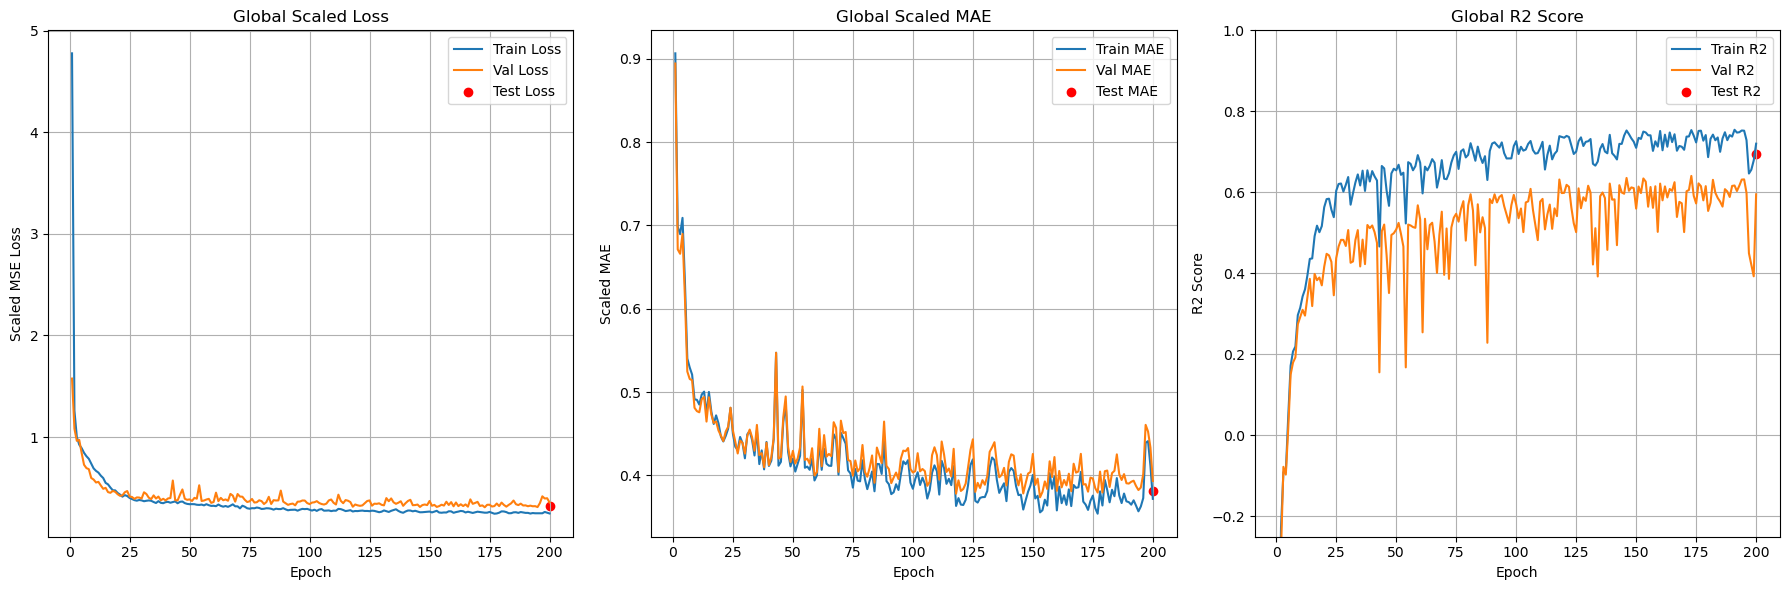

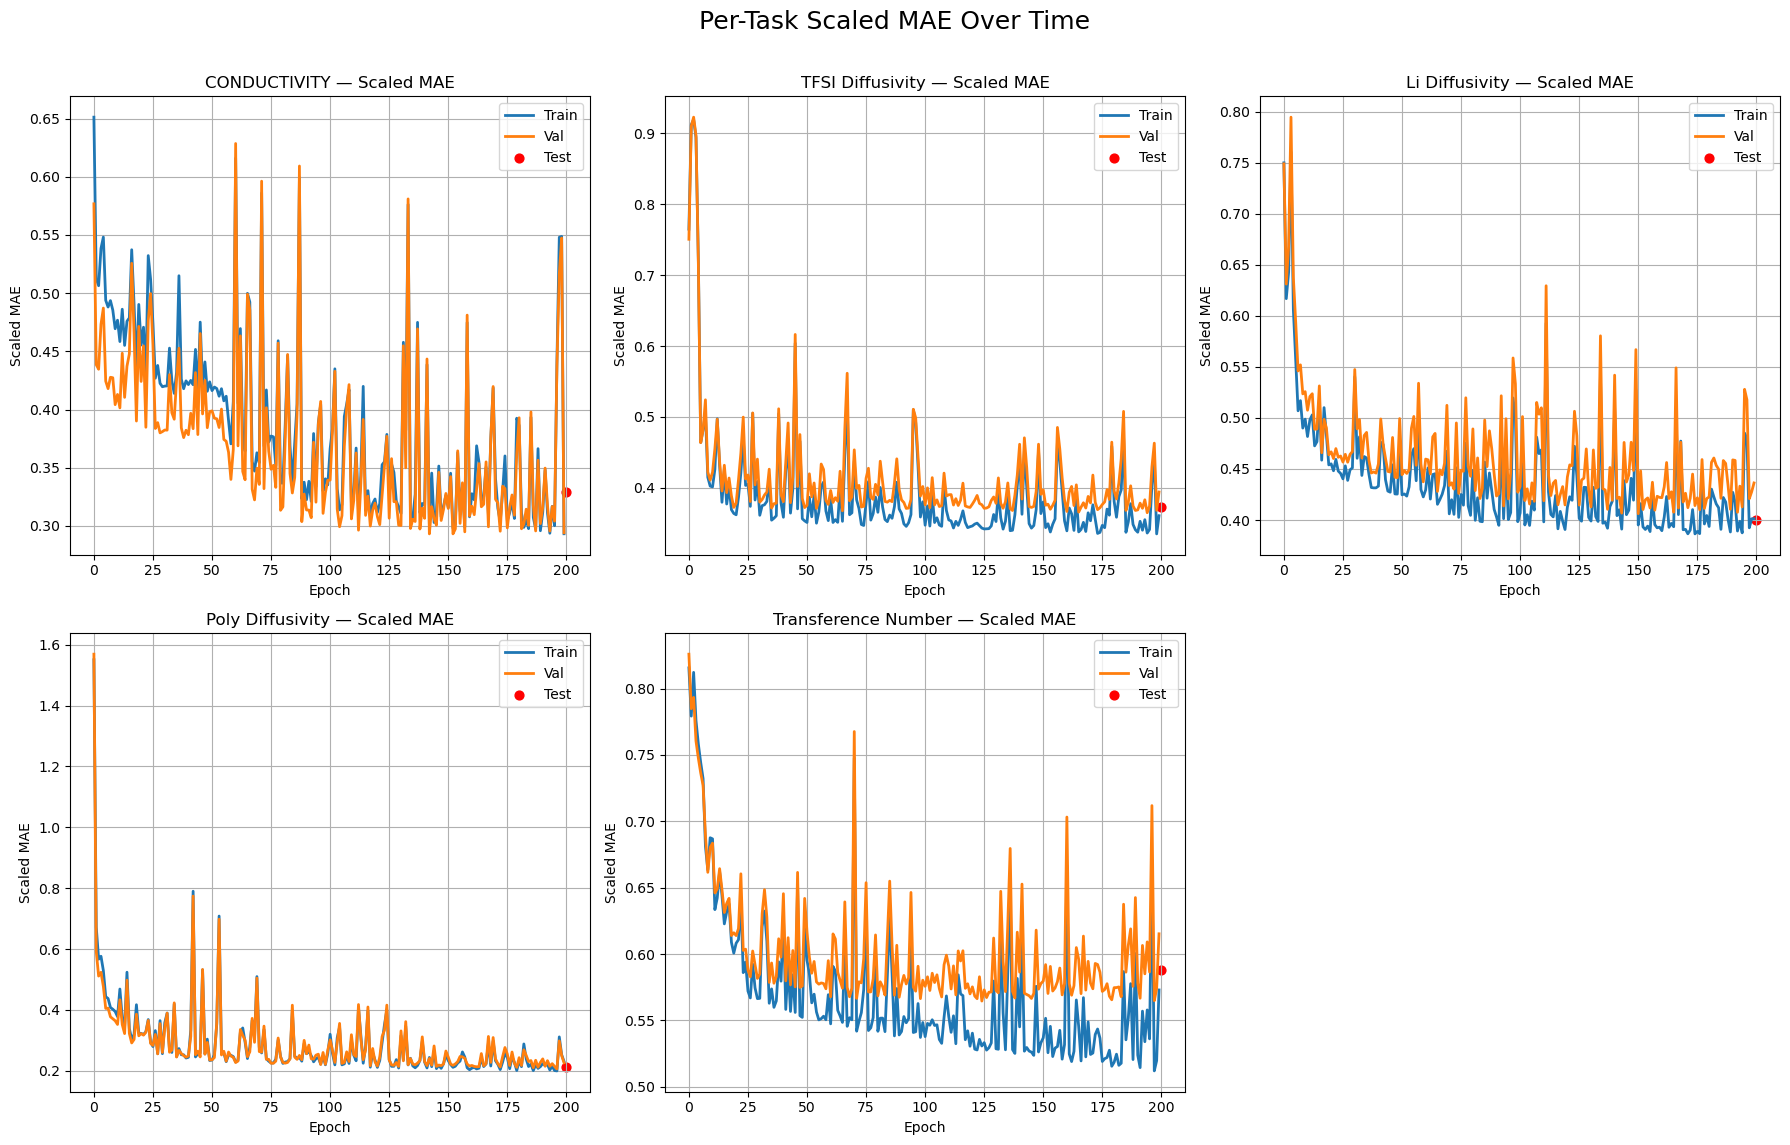

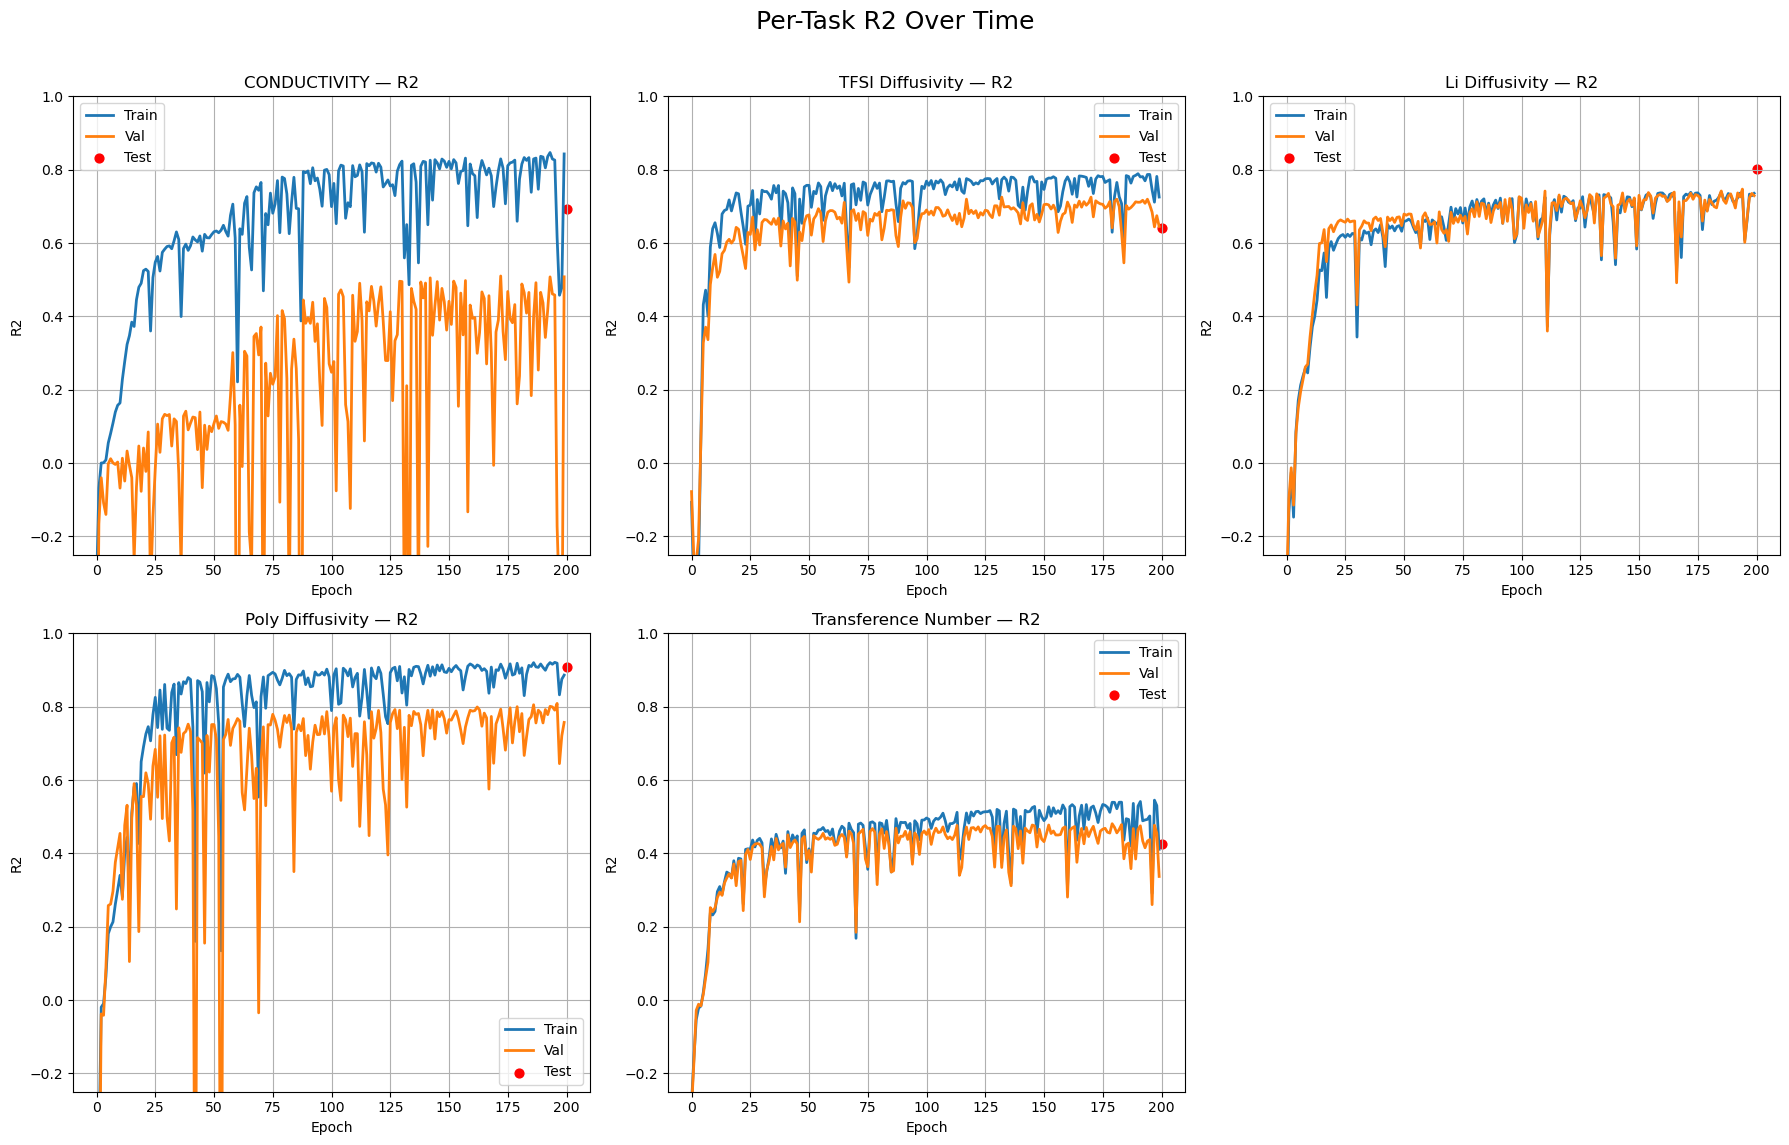

In [15]:
combined_metrics = combine_metric_dict([naive_metrics[c] for c in target_cols_labels_full], target_cols_labels_full)
plot_all_metrics(combined_metrics, target_cols_labels_full)

# Hyperparameter optimization (with and without molecular features)

In [16]:
hyperparameter_searchspace_long = {
    "batch_size":    Integer(32, 1024, prior='log-uniform', base=2),
    "num_epochs":    Integer(64, 256),
    "fea_dim":       Integer(32, 128),
    "n_layers":      Integer(2, 8),
    "n_hidden":      Integer(2, 8),
    "learning_rate": Real(1e-6, 1e-3, prior='log-uniform'),
    "weight_decay":  Real(1e-8, 1e-3, prior='log-uniform'),
}

In [17]:
class CGCNN_Estimator(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        csv_path,
        target_cols,
        include_mol_features=False,
        batch_size=batch_size,
        num_epochs=num_epochs,
        fea_dim=fea_dim,
        n_layers=n_layers,
        n_hidden=n_hidden,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        verbose=0
    ):
        # static info
        self.csv_path = csv_path
        self.target_cols = target_cols
        self.include_mol_features = include_mol_features
        self.verbose = verbose

        # hyperparameters (optimizable)
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.fea_dim = fea_dim
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        # results & state
        self.model_ = None
        self.metrics_ = None
        self.scaler_ = None
        self.test_preds_ = None
        self.test_targets_ = None
        self.test_masks_ = None

    def fit(self, X=None, y=None):
        (self.model_,
         self.metrics_,
         self.scaler_,
         self.test_preds_,
         self.test_targets_,
         self.test_masks_) = model_execution(
            csv_path=self.csv_path,
            target_cols=self.target_cols,
            include_mol_features=self.include_mol_features,
            batch_size=self.batch_size,
            num_epochs=self.num_epochs,
            fea_dim=self.fea_dim,
            n_layers=self.n_layers,
            n_hidden=self.n_hidden,
            learning_rate=self.learning_rate,
            weight_decay=self.weight_decay,
            return_predictions=True,
            verbose=self.verbose
        )

        return self
    
    def score(self, X, y=None):
        r2 = self.metrics_["test"]["r2"]
        mae = self.metrics_["test"]["mae"]
        return r2 - MAE_MULT * mae
    
    def predict(self, X):
        # optional, not needed for BayesSearchCV
        pass

In [18]:
estimator_nomol = {
    k: CGCNN_Estimator(
        csv_path=csv_path,
        target_cols=k,
        include_mol_features=False
    ) for k in target_cols_labels_full
}

estimator_withmol = {
    k: CGCNN_Estimator(
        csv_path=csv_path,
        target_cols=k,
        include_mol_features=True
    ) for k in target_cols_labels_full
}

dummy_X = np.zeros((2, 1))
dummy_y = np.zeros((2, 1))
dummy_split = PredefinedSplit(test_fold=[-1, 0])

In [19]:
optimizer_nomol = {
    k: BayesSearchCV(
        estimator=estimator_nomol[k],
        search_spaces=hyperparameter_searchspace_long,
        n_iter=N_OPT_ITER,
        cv=dummy_split,
        n_jobs=1,
        verbose=3,
    ) for k in target_cols_labels_full
}

optimizer_withmol = {
    k: BayesSearchCV(
        estimator=estimator_withmol[k],
        search_spaces=hyperparameter_searchspace_long,
        n_iter=N_OPT_ITER,
        cv=dummy_split,
        n_jobs=1,
        verbose=3,
    ) for k in target_cols_labels_full
}

In [20]:
for k in target_cols_labels_full:
    optimizer_nomol[k].fit(dummy_X, dummy_y)
    optimizer_withmol[k].fit(dummy_X, dummy_y)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 219/219 [00:42<00:00,  5.15it/s]


[CV 1/1] END batch_size=314, fea_dim=118, learning_rate=3.9648465997250265e-05, n_hidden=3, n_layers=3, num_epochs=219, weight_decay=5.968658790813751e-05;, score=0.109 total time=  45.5s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 143/143 [00:31<00:00,  4.54it/s]


[CV 1/1] END batch_size=220, fea_dim=59, learning_rate=9.950972714761189e-06, n_hidden=5, n_layers=6, num_epochs=143, weight_decay=7.233103599769947e-06;, score=-0.374 total time=  34.4s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 179/179 [00:55<00:00,  3.22it/s]


[CV 1/1] END batch_size=88, fea_dim=36, learning_rate=0.0005830318812269394, n_hidden=6, n_layers=3, num_epochs=179, weight_decay=1.9718349825979946e-07;, score=0.149 total time=  58.5s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 184/184 [00:37<00:00,  4.97it/s]


[CV 1/1] END batch_size=356, fea_dim=114, learning_rate=0.00032608527356368434, n_hidden=5, n_layers=4, num_epochs=184, weight_decay=1.25378486024711e-08;, score=0.179 total time=  40.0s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 220/220 [01:55<00:00,  1.90it/s]


[CV 1/1] END batch_size=59, fea_dim=111, learning_rate=1.9761740165774116e-05, n_hidden=4, n_layers=7, num_epochs=220, weight_decay=3.833020783818662e-05;, score=0.201 total time= 2.0min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 220/220 [01:19<00:00,  2.75it/s]


[CV 1/1] END batch_size=76, fea_dim=55, learning_rate=2.636565998912856e-06, n_hidden=4, n_layers=4, num_epochs=220, weight_decay=1.0163545733680777e-05;, score=-0.080 total time= 1.4min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 129/129 [01:27<00:00,  1.47it/s]


[CV 1/1] END batch_size=42, fea_dim=68, learning_rate=3.657438130614001e-06, n_hidden=7, n_layers=6, num_epochs=129, weight_decay=2.1005380290350729e-07;, score=0.072 total time= 1.5min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 66/66 [00:09<00:00,  7.26it/s]


[CV 1/1] END batch_size=927, fea_dim=76, learning_rate=6.13812911749608e-06, n_hidden=2, n_layers=2, num_epochs=66, weight_decay=3.1985156572342655e-07;, score=-0.917 total time=  12.1s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 233/233 [03:06<00:00,  1.25it/s]


[CV 1/1] END batch_size=34, fea_dim=87, learning_rate=2.392570147520359e-05, n_hidden=6, n_layers=6, num_epochs=233, weight_decay=4.0702023600769696e-06;, score=0.130 total time= 3.2min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]


[CV 1/1] END batch_size=429, fea_dim=120, learning_rate=0.0007777650912697029, n_hidden=7, n_layers=5, num_epochs=126, weight_decay=4.106576630381968e-08;, score=-0.660 total time=  30.7s


100%|██████████| 220/220 [02:05<00:00,  1.75it/s]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 95/95 [00:23<00:00,  4.00it/s]


[CV 1/1] END batch_size=189, fea_dim=91, learning_rate=2.412116154324712e-06, n_hidden=7, n_layers=6, num_epochs=95, weight_decay=0.0005825772825925326;, score=-0.458 total time=  26.8s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 129/129 [01:00<00:00,  2.14it/s]


[CV 1/1] END batch_size=52, fea_dim=76, learning_rate=2.397674801602219e-05, n_hidden=3, n_layers=3, num_epochs=129, weight_decay=0.00011127288054295195;, score=-0.442 total time= 1.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 134/134 [01:09<00:00,  1.94it/s]


[CV 1/1] END batch_size=58, fea_dim=39, learning_rate=0.00020001136266292963, n_hidden=2, n_layers=7, num_epochs=134, weight_decay=0.0006673819161762589;, score=0.172 total time= 1.2min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 85/85 [00:14<00:00,  5.75it/s]


[CV 1/1] END batch_size=354, fea_dim=34, learning_rate=0.00025738450643282947, n_hidden=7, n_layers=4, num_epochs=85, weight_decay=4.794850099627222e-05;, score=-0.748 total time=  17.9s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 126/126 [00:36<00:00,  3.46it/s]


[CV 1/1] END batch_size=84, fea_dim=44, learning_rate=4.6880076501894546e-05, n_hidden=2, n_layers=2, num_epochs=126, weight_decay=4.760373456076189e-05;, score=-0.344 total time=  39.5s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 108/108 [00:23<00:00,  4.61it/s]


[CV 1/1] END batch_size=217, fea_dim=70, learning_rate=6.901505490940549e-05, n_hidden=7, n_layers=4, num_epochs=108, weight_decay=4.6242909935403375e-05;, score=0.012 total time=  26.5s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 141/141 [00:42<00:00,  3.34it/s]


[CV 1/1] END batch_size=223, fea_dim=114, learning_rate=0.00044587785833902866, n_hidden=5, n_layers=7, num_epochs=141, weight_decay=8.555192101418181e-05;, score=0.056 total time=  45.5s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 194/194 [00:28<00:00,  6.85it/s]


[CV 1/1] END batch_size=457, fea_dim=50, learning_rate=0.0003500895139108488, n_hidden=6, n_layers=2, num_epochs=194, weight_decay=0.0005684363415926183;, score=-0.032 total time=  31.3s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 187/187 [01:14<00:00,  2.51it/s]


[CV 1/1] END batch_size=97, fea_dim=76, learning_rate=1.6269113456788696e-05, n_hidden=8, n_layers=8, num_epochs=187, weight_decay=0.00045659638041870644;, score=0.062 total time= 1.3min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 245/245 [00:59<00:00,  4.15it/s]


[CV 1/1] END batch_size=134, fea_dim=39, learning_rate=0.00014088664934258402, n_hidden=3, n_layers=3, num_epochs=245, weight_decay=0.00023171826243711022;, score=0.001 total time= 1.0min


100%|██████████| 134/134 [01:10<00:00,  1.90it/s]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 76/76 [00:26<00:00,  2.90it/s]


[CV 1/1] END batch_size=95, fea_dim=85, learning_rate=0.00015919076000777473, n_hidden=5, n_layers=5, num_epochs=76, weight_decay=3.969692516412719e-08;, score=0.065 total time=  29.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 173/173 [02:21<00:00,  1.22it/s]


[CV 1/1] END batch_size=34, fea_dim=78, learning_rate=2.1936330404667386e-05, n_hidden=4, n_layers=7, num_epochs=173, weight_decay=6.448168974111245e-08;, score=-0.027 total time= 2.4min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 116/116 [01:27<00:00,  1.32it/s]


[CV 1/1] END batch_size=34, fea_dim=73, learning_rate=0.0001619814523296936, n_hidden=3, n_layers=6, num_epochs=116, weight_decay=7.381876952661056e-08;, score=-0.090 total time= 1.5min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 150/150 [00:24<00:00,  6.20it/s]


[CV 1/1] END batch_size=512, fea_dim=93, learning_rate=3.665887052964749e-05, n_hidden=2, n_layers=3, num_epochs=150, weight_decay=2.5516488608653582e-05;, score=-0.151 total time=  27.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 123/123 [00:25<00:00,  4.91it/s]


[CV 1/1] END batch_size=472, fea_dim=67, learning_rate=0.0002061948321444649, n_hidden=4, n_layers=8, num_epochs=123, weight_decay=1.3554543456884583e-07;, score=-0.009 total time=  28.1s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 102/102 [00:17<00:00,  5.77it/s]


[CV 1/1] END batch_size=350, fea_dim=83, learning_rate=8.92917806909912e-06, n_hidden=4, n_layers=2, num_epochs=102, weight_decay=6.8252746124867e-07;, score=-0.466 total time=  20.8s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 155/155 [00:32<00:00,  4.76it/s]


[CV 1/1] END batch_size=683, fea_dim=107, learning_rate=1.34276867950485e-06, n_hidden=3, n_layers=5, num_epochs=155, weight_decay=5.75603319623679e-06;, score=-0.872 total time=  35.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 153/153 [00:35<00:00,  4.31it/s]


[CV 1/1] END batch_size=202, fea_dim=99, learning_rate=0.00021614138107930498, n_hidden=6, n_layers=4, num_epochs=153, weight_decay=1.8602219980056954e-08;, score=0.055 total time=  38.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 232/232 [01:15<00:00,  3.09it/s]


[CV 1/1] END batch_size=104, fea_dim=96, learning_rate=4.183256805925871e-05, n_hidden=6, n_layers=4, num_epochs=232, weight_decay=1.5302697521781458e-07;, score=-0.036 total time= 1.3min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 114/114 [00:19<00:00,  5.76it/s]


[CV 1/1] END batch_size=476, fea_dim=37, learning_rate=0.00042146126953161375, n_hidden=7, n_layers=6, num_epochs=114, weight_decay=0.0009662188645051055;, score=-0.073 total time=  22.9s


100%|██████████| 76/76 [00:27<00:00,  2.72it/s]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 193/193 [00:59<00:00,  3.22it/s]


[CV 1/1] END batch_size=121, fea_dim=66, learning_rate=0.00016585692408966731, n_hidden=5, n_layers=5, num_epochs=193, weight_decay=4.041649107997094e-06;, score=-0.308 total time= 1.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 228/228 [02:27<00:00,  1.55it/s]


[CV 1/1] END batch_size=61, fea_dim=80, learning_rate=2.2974486922078723e-06, n_hidden=8, n_layers=7, num_epochs=228, weight_decay=0.0008794445035098099;, score=-0.027 total time= 2.5min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 92/92 [00:46<00:00,  1.97it/s]


[CV 1/1] END batch_size=52, fea_dim=105, learning_rate=0.0002153505020211677, n_hidden=5, n_layers=3, num_epochs=92, weight_decay=3.32946744321156e-05;, score=-0.015 total time=  49.8s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 197/197 [00:58<00:00,  3.34it/s]


[CV 1/1] END batch_size=151, fea_dim=65, learning_rate=0.0008469329163742914, n_hidden=4, n_layers=8, num_epochs=197, weight_decay=1.9657554210465026e-08;, score=-0.190 total time= 1.0min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 69/69 [00:30<00:00,  2.28it/s]


[CV 1/1] END batch_size=86, fea_dim=86, learning_rate=0.0002439603787917971, n_hidden=5, n_layers=8, num_epochs=69, weight_decay=1.431889360350482e-07;, score=-0.093 total time=  33.4s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 195/195 [01:41<00:00,  1.93it/s]


[CV 1/1] END batch_size=44, fea_dim=40, learning_rate=0.0006966453547949775, n_hidden=3, n_layers=3, num_epochs=195, weight_decay=7.545661330662047e-08;, score=0.032 total time= 1.7min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 215/215 [00:44<00:00,  4.87it/s]


[CV 1/1] END batch_size=230, fea_dim=108, learning_rate=7.287368064580958e-05, n_hidden=7, n_layers=2, num_epochs=215, weight_decay=1.0296422706924025e-05;, score=0.001 total time=  47.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 176/176 [01:11<00:00,  2.47it/s]


[CV 1/1] END batch_size=74, fea_dim=49, learning_rate=1.1724061922923015e-05, n_hidden=2, n_layers=5, num_epochs=176, weight_decay=3.0255261439205795e-05;, score=-0.037 total time= 1.2min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 158/158 [00:49<00:00,  3.20it/s]


[CV 1/1] END batch_size=228, fea_dim=127, learning_rate=0.0004905694036645531, n_hidden=4, n_layers=7, num_epochs=158, weight_decay=1.1227499556162567e-07;, score=-0.199 total time=  52.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 202/202 [00:36<00:00,  5.49it/s]


[CV 1/1] END batch_size=382, fea_dim=82, learning_rate=5.527761062581778e-05, n_hidden=8, n_layers=3, num_epochs=202, weight_decay=1.2283531819307079e-05;, score=-0.054 total time=  39.9s


100%|██████████| 195/195 [01:43<00:00,  1.89it/s]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 109/109 [00:25<00:00,  4.29it/s]


[CV 1/1] END batch_size=659, fea_dim=119, learning_rate=0.00011396721017052668, n_hidden=3, n_layers=6, num_epochs=109, weight_decay=1.7717728231596434e-06;, score=-0.203 total time=  28.5s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 177/177 [01:46<00:00,  1.67it/s]


[CV 1/1] END batch_size=34, fea_dim=94, learning_rate=0.00030602608987307186, n_hidden=5, n_layers=2, num_epochs=177, weight_decay=1.2061352535995283e-05;, score=0.013 total time= 1.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 114/114 [00:59<00:00,  1.92it/s]


[CV 1/1] END batch_size=65, fea_dim=48, learning_rate=2.3150508703317277e-06, n_hidden=5, n_layers=7, num_epochs=114, weight_decay=3.413207443685936e-05;, score=-0.864 total time= 1.0min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 117/117 [01:16<00:00,  1.52it/s]


[CV 1/1] END batch_size=37, fea_dim=91, learning_rate=0.0005047374890431209, n_hidden=4, n_layers=4, num_epochs=117, weight_decay=1.4084641577245957e-07;, score=-0.491 total time= 1.3min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 178/178 [01:59<00:00,  1.49it/s]


[CV 1/1] END batch_size=34, fea_dim=113, learning_rate=9.181751257714189e-06, n_hidden=6, n_layers=3, num_epochs=178, weight_decay=0.0003831927703413529;, score=-0.071 total time= 2.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 251/251 [01:12<00:00,  3.47it/s]


[CV 1/1] END batch_size=163, fea_dim=126, learning_rate=2.2747320264404407e-05, n_hidden=5, n_layers=5, num_epochs=251, weight_decay=6.250517520117388e-05;, score=-0.090 total time= 1.3min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 234/234 [00:46<00:00,  5.06it/s]


[CV 1/1] END batch_size=321, fea_dim=73, learning_rate=0.0006243405587740941, n_hidden=2, n_layers=6, num_epochs=234, weight_decay=2.2807643702655984e-05;, score=-0.016 total time=  49.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 211/211 [00:37<00:00,  5.67it/s]


[CV 1/1] END batch_size=275, fea_dim=66, learning_rate=3.490932327360244e-05, n_hidden=2, n_layers=3, num_epochs=211, weight_decay=0.0005420013734530241;, score=-0.335 total time=  40.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 113/113 [00:17<00:00,  6.62it/s]


[CV 1/1] END batch_size=524, fea_dim=66, learning_rate=6.162065498224294e-06, n_hidden=4, n_layers=2, num_epochs=113, weight_decay=8.395050912756625e-08;, score=-0.580 total time=  20.1s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 77/77 [00:15<00:00,  5.04it/s]


[CV 1/1] END batch_size=683, fea_dim=81, learning_rate=0.00015804781856520135, n_hidden=8, n_layers=7, num_epochs=77, weight_decay=1.6070403020413008e-08;, score=-0.201 total time=  18.3s


100%|██████████| 177/177 [01:40<00:00,  1.75it/s]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 179/179 [01:51<00:00,  1.61it/s]


[CV 1/1] END batch_size=58, fea_dim=67, learning_rate=4.2190865691389295e-05, n_hidden=7, n_layers=7, num_epochs=179, weight_decay=3.830148792133048e-06;, score=-0.029 total time= 1.9min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 130/130 [00:53<00:00,  2.41it/s]


[CV 1/1] END batch_size=52, fea_dim=70, learning_rate=4.107676357675364e-06, n_hidden=5, n_layers=2, num_epochs=130, weight_decay=3.506762982745363e-07;, score=-0.400 total time=  57.1s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [01:02<00:00,  4.08it/s]


[CV 1/1] END batch_size=122, fea_dim=89, learning_rate=1.3587503600158176e-05, n_hidden=6, n_layers=2, num_epochs=256, weight_decay=1.8235077003747373e-05;, score=-0.068 total time= 1.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 183/183 [00:45<00:00,  4.00it/s]


[CV 1/1] END batch_size=196, fea_dim=99, learning_rate=4.437006036943958e-06, n_hidden=7, n_layers=5, num_epochs=183, weight_decay=6.391064567426074e-05;, score=-0.175 total time=  48.7s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 207/207 [01:44<00:00,  1.98it/s]


[CV 1/1] END batch_size=70, fea_dim=91, learning_rate=0.0003946219046899153, n_hidden=8, n_layers=7, num_epochs=207, weight_decay=4.9039557561787504e-08;, score=-0.392 total time= 1.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 243/243 [00:56<00:00,  4.30it/s]


[CV 1/1] END batch_size=389, fea_dim=110, learning_rate=0.0008102763702332006, n_hidden=4, n_layers=7, num_epochs=243, weight_decay=1.1676527878126664e-07;, score=-0.052 total time=  59.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 230/230 [00:41<00:00,  5.56it/s]


[CV 1/1] END batch_size=526, fea_dim=104, learning_rate=2.3907271844483097e-06, n_hidden=4, n_layers=3, num_epochs=230, weight_decay=0.0005595439858337653;, score=-0.611 total time=  44.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 162/162 [00:38<00:00,  4.22it/s]


[CV 1/1] END batch_size=208, fea_dim=84, learning_rate=1.8310290238377898e-06, n_hidden=3, n_layers=5, num_epochs=162, weight_decay=0.00020829736856324316;, score=-0.624 total time=  41.4s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [00:48<00:00,  5.24it/s]


[CV 1/1] END batch_size=309, fea_dim=85, learning_rate=2.6611918490974358e-05, n_hidden=4, n_layers=4, num_epochs=256, weight_decay=2.641262235876604e-06;, score=-0.400 total time=  51.9s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


[CV 1/1] END batch_size=53, fea_dim=105, learning_rate=2.035954704866125e-06, n_hidden=5, n_layers=4, num_epochs=100, weight_decay=9.573066201130496e-08;, score=-0.690 total time=  57.8s


100%|██████████| 179/179 [01:54<00:00,  1.56it/s]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 118/118 [00:26<00:00,  4.38it/s]


[CV 1/1] END batch_size=221, fea_dim=56, learning_rate=8.646165629871486e-05, n_hidden=2, n_layers=6, num_epochs=118, weight_decay=1.9601371474982953e-07;, score=0.341 total time=  30.0s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 135/135 [00:34<00:00,  3.94it/s]


[CV 1/1] END batch_size=196, fea_dim=38, learning_rate=0.0007154434578064869, n_hidden=3, n_layers=8, num_epochs=135, weight_decay=0.00043767043851842424;, score=0.394 total time=  37.4s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 255/255 [01:19<00:00,  3.21it/s]


[CV 1/1] END batch_size=114, fea_dim=94, learning_rate=4.054625021580955e-05, n_hidden=6, n_layers=5, num_epochs=255, weight_decay=0.0002859124231490288;, score=0.464 total time= 1.4min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 209/209 [01:42<00:00,  2.03it/s]


[CV 1/1] END batch_size=55, fea_dim=46, learning_rate=0.0001266541539637734, n_hidden=7, n_layers=4, num_epochs=209, weight_decay=3.8903006011423953e-07;, score=0.503 total time= 1.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 234/234 [00:47<00:00,  4.88it/s]


[CV 1/1] END batch_size=631, fea_dim=99, learning_rate=5.793008758534275e-05, n_hidden=7, n_layers=6, num_epochs=234, weight_decay=4.954017133514337e-08;, score=0.453 total time=  51.0s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 253/253 [00:40<00:00,  6.22it/s]


[CV 1/1] END batch_size=553, fea_dim=41, learning_rate=7.110330124439018e-05, n_hidden=7, n_layers=5, num_epochs=253, weight_decay=2.3083007952908333e-07;, score=0.470 total time=  43.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 197/197 [00:52<00:00,  3.76it/s]


[CV 1/1] END batch_size=222, fea_dim=109, learning_rate=1.135218194887944e-05, n_hidden=5, n_layers=7, num_epochs=197, weight_decay=6.295498283259684e-08;, score=0.395 total time=  55.4s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 230/230 [00:41<00:00,  5.59it/s]


[CV 1/1] END batch_size=443, fea_dim=93, learning_rate=3.170186867341294e-06, n_hidden=8, n_layers=3, num_epochs=230, weight_decay=1.2889477057293024e-06;, score=-0.621 total time=  44.1s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 238/238 [01:23<00:00,  2.86it/s]


[CV 1/1] END batch_size=102, fea_dim=41, learning_rate=5.80618558908991e-05, n_hidden=4, n_layers=6, num_epochs=238, weight_decay=1.0540216436649718e-05;, score=0.370 total time= 1.4min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 93/93 [00:20<00:00,  4.61it/s]


[CV 1/1] END batch_size=273, fea_dim=60, learning_rate=0.0001912248191311805, n_hidden=8, n_layers=3, num_epochs=93, weight_decay=1.080346966213537e-07;, score=0.454 total time=  23.3s


100%|██████████| 209/209 [01:42<00:00,  2.04it/s]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 215/215 [00:37<00:00,  5.68it/s]


[CV 1/1] END batch_size=389, fea_dim=74, learning_rate=0.0005557022889672539, n_hidden=4, n_layers=4, num_epochs=215, weight_decay=2.2315024696007071e-07;, score=0.499 total time=  41.1s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 123/123 [00:19<00:00,  6.38it/s]


[CV 1/1] END batch_size=814, fea_dim=69, learning_rate=1.6399481470788694e-06, n_hidden=3, n_layers=3, num_epochs=123, weight_decay=2.0594870009127413e-06;, score=-0.963 total time=  22.4s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 76/76 [00:16<00:00,  4.71it/s]


[CV 1/1] END batch_size=260, fea_dim=59, learning_rate=3.979753836222778e-06, n_hidden=6, n_layers=5, num_epochs=76, weight_decay=6.577800408419581e-06;, score=-0.152 total time=  19.3s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 178/178 [02:06<00:00,  1.41it/s]


[CV 1/1] END batch_size=49, fea_dim=98, learning_rate=6.21114308414998e-05, n_hidden=5, n_layers=7, num_epochs=178, weight_decay=2.649238129274852e-06;, score=0.461 total time= 2.2min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 217/217 [00:38<00:00,  5.59it/s]


[CV 1/1] END batch_size=483, fea_dim=64, learning_rate=0.00015583542441006525, n_hidden=6, n_layers=3, num_epochs=217, weight_decay=2.2414013768206382e-05;, score=0.419 total time=  41.8s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 117/117 [00:26<00:00,  4.47it/s]


[CV 1/1] END batch_size=243, fea_dim=97, learning_rate=7.66080654379595e-05, n_hidden=7, n_layers=4, num_epochs=117, weight_decay=3.981888555475336e-05;, score=0.379 total time=  29.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 193/193 [00:49<00:00,  3.88it/s]


[CV 1/1] END batch_size=116, fea_dim=99, learning_rate=0.0005355335694629904, n_hidden=6, n_layers=2, num_epochs=193, weight_decay=2.5736087724896853e-06;, score=0.475 total time=  52.8s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 250/250 [00:50<00:00,  4.94it/s]


[CV 1/1] END batch_size=753, fea_dim=75, learning_rate=8.871312981180165e-05, n_hidden=3, n_layers=8, num_epochs=250, weight_decay=2.3021022205652273e-08;, score=0.463 total time=  53.7s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 150/150 [00:21<00:00,  7.01it/s]


[CV 1/1] END batch_size=812, fea_dim=44, learning_rate=0.0005322443690867322, n_hidden=7, n_layers=2, num_epochs=150, weight_decay=9.049210616771143e-07;, score=0.387 total time=  24.4s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 199/199 [01:09<00:00,  2.84it/s]


[CV 1/1] END batch_size=117, fea_dim=69, learning_rate=2.8169002579602953e-06, n_hidden=6, n_layers=8, num_epochs=199, weight_decay=0.00027837388995616497;, score=0.400 total time= 1.2min


100%|██████████| 215/215 [00:37<00:00,  5.78it/s]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 118/118 [01:12<00:00,  1.62it/s]


[CV 1/1] END batch_size=40, fea_dim=107, learning_rate=0.0009878451833897218, n_hidden=5, n_layers=4, num_epochs=118, weight_decay=2.1486191626131155e-08;, score=-0.643 total time= 1.3min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 106/106 [00:41<00:00,  2.57it/s]


[CV 1/1] END batch_size=82, fea_dim=46, learning_rate=5.187183030124073e-06, n_hidden=4, n_layers=5, num_epochs=106, weight_decay=6.514920074004226e-05;, score=-0.766 total time=  44.4s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 229/229 [00:34<00:00,  6.58it/s]


[CV 1/1] END batch_size=762, fea_dim=37, learning_rate=2.3943625265594273e-06, n_hidden=5, n_layers=4, num_epochs=229, weight_decay=2.67094943940454e-08;, score=-1.390 total time=  38.1s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 252/252 [03:46<00:00,  1.11it/s]


[CV 1/1] END batch_size=35, fea_dim=108, learning_rate=0.0008726242581430353, n_hidden=7, n_layers=8, num_epochs=252, weight_decay=0.0007368063500184272;, score=-0.585 total time= 3.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 209/209 [02:58<00:00,  1.17it/s]


[CV 1/1] END batch_size=32, fea_dim=95, learning_rate=0.00026378644831498676, n_hidden=6, n_layers=6, num_epochs=209, weight_decay=9.776125088097935e-08;, score=-0.683 total time= 3.0min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 211/211 [00:35<00:00,  6.03it/s]


[CV 1/1] END batch_size=751, fea_dim=66, learning_rate=0.000548133224721789, n_hidden=2, n_layers=5, num_epochs=211, weight_decay=1.7673023752398817e-06;, score=-0.780 total time=  38.0s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 253/253 [03:01<00:00,  1.39it/s]


[CV 1/1] END batch_size=36, fea_dim=86, learning_rate=0.0003767470151616461, n_hidden=7, n_layers=5, num_epochs=253, weight_decay=1.1792745299424578e-08;, score=-0.695 total time= 3.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 254/254 [00:47<00:00,  5.39it/s]


[CV 1/1] END batch_size=232, fea_dim=34, learning_rate=0.00030626345554355126, n_hidden=7, n_layers=2, num_epochs=254, weight_decay=3.1497365975329125e-08;, score=-0.688 total time=  50.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 245/245 [01:04<00:00,  3.79it/s]


[CV 1/1] END batch_size=159, fea_dim=60, learning_rate=0.0003983402440059854, n_hidden=8, n_layers=6, num_epochs=245, weight_decay=1.0796023901012112e-05;, score=-0.618 total time= 1.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 76/76 [00:14<00:00,  5.21it/s]


[CV 1/1] END batch_size=329, fea_dim=71, learning_rate=3.8301169628915e-05, n_hidden=3, n_layers=5, num_epochs=76, weight_decay=0.0005467378093314353;, score=-0.775 total time=  17.6s


100%|██████████| 252/252 [03:44<00:00,  1.12it/s]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


[CV 1/1] END batch_size=409, fea_dim=110, learning_rate=0.00034391698672852413, n_hidden=2, n_layers=8, num_epochs=86, weight_decay=1.8244044651917685e-05;, score=-0.724 total time=  24.7s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 184/184 [00:37<00:00,  4.95it/s]


[CV 1/1] END batch_size=304, fea_dim=80, learning_rate=3.076250438041886e-06, n_hidden=4, n_layers=5, num_epochs=184, weight_decay=1.1741842124689167e-05;, score=-0.847 total time=  40.3s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 218/218 [00:36<00:00,  5.92it/s]


[CV 1/1] END batch_size=365, fea_dim=43, learning_rate=4.25537949135593e-05, n_hidden=8, n_layers=3, num_epochs=218, weight_decay=8.040929781181305e-07;, score=-0.720 total time=  39.8s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 241/241 [00:39<00:00,  6.14it/s]


[CV 1/1] END batch_size=957, fea_dim=80, learning_rate=0.0001740985620709457, n_hidden=5, n_layers=4, num_epochs=241, weight_decay=3.797695340658657e-08;, score=-0.678 total time=  42.1s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 79/79 [00:45<00:00,  1.74it/s]


[CV 1/1] END batch_size=58, fea_dim=69, learning_rate=1.936047064920576e-06, n_hidden=7, n_layers=5, num_epochs=79, weight_decay=9.996070650712358e-05;, score=-1.045 total time=  48.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 90/90 [00:15<00:00,  5.90it/s]


[CV 1/1] END batch_size=724, fea_dim=97, learning_rate=9.513462261251921e-06, n_hidden=5, n_layers=3, num_epochs=90, weight_decay=0.00013575927547785515;, score=-1.007 total time=  18.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 239/239 [01:53<00:00,  2.11it/s]


[CV 1/1] END batch_size=63, fea_dim=105, learning_rate=6.688788249227336e-06, n_hidden=6, n_layers=4, num_epochs=239, weight_decay=1.1454760990293706e-05;, score=-0.678 total time= 1.9min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 126/126 [00:18<00:00,  6.72it/s]


[CV 1/1] END batch_size=710, fea_dim=71, learning_rate=9.08921739543765e-06, n_hidden=5, n_layers=2, num_epochs=126, weight_decay=7.298819114146584e-05;, score=-1.151 total time=  21.7s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 220/220 [00:41<00:00,  5.27it/s]


[CV 1/1] END batch_size=271, fea_dim=50, learning_rate=4.7134220819994126e-05, n_hidden=6, n_layers=4, num_epochs=220, weight_decay=1.843823880960223e-07;, score=-0.743 total time=  44.8s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 147/147 [00:38<00:00,  3.77it/s]


[CV 1/1] END batch_size=253, fea_dim=110, learning_rate=1.7050699491428553e-05, n_hidden=4, n_layers=7, num_epochs=147, weight_decay=5.551952376430279e-06;, score=-0.617 total time=  42.0s


100%|██████████| 147/147 [00:39<00:00,  3.75it/s]


In [21]:
best_model_hyp_nomol = {k: optimizer_nomol[k].best_estimator_ for k in target_cols_labels_full}
best_params_nomol = {k: best_model_hyp_nomol[k].get_params() for k in target_cols_labels_full}

best_model_hyp_withmol = {k: optimizer_withmol[k].best_estimator_ for k in target_cols_labels_full}
best_params_withmol = {k: best_model_hyp_withmol[k].get_params() for k in target_cols_labels_full}

In [30]:
final_model_nomol, final_metrics_nomol = dict(), dict()
for k in target_cols_labels_full:
    score_nomol = -1000
    while score_nomol < (optimizer_nomol[k].best_score_ - 0.05):
        final_model_nomol[k], final_metrics_nomol[k], _ = model_execution(**best_params_nomol[k])
        score_nomol = final_metrics_nomol[k]['test']['r2'] - MAE_MULT * final_metrics_nomol[k]['test']['mae']
        print(score_nomol)

100%|██████████| 220/220 [02:00<00:00,  1.83it/s]


0.12596440315246582


100%|██████████| 220/220 [01:58<00:00,  1.85it/s]


-0.00968259572982788


100%|██████████| 220/220 [02:03<00:00,  1.77it/s]


0.14501047134399414


100%|██████████| 220/220 [02:07<00:00,  1.73it/s]


0.12506425380706787


100%|██████████| 220/220 [02:06<00:00,  1.74it/s]


-0.039861321449279785


100%|██████████| 220/220 [02:03<00:00,  1.78it/s]


0.11845171451568604


100%|██████████| 220/220 [01:59<00:00,  1.84it/s]


0.17788690328598022


100%|██████████| 76/76 [00:26<00:00,  2.89it/s]


-0.0809330940246582


100%|██████████| 76/76 [00:26<00:00,  2.85it/s]


-0.10179364681243896


100%|██████████| 76/76 [00:26<00:00,  2.84it/s]


-0.06437951326370239


100%|██████████| 76/76 [00:26<00:00,  2.86it/s]


-0.06626743078231812


100%|██████████| 76/76 [00:26<00:00,  2.89it/s]


0.0011884570121765137


100%|██████████| 76/76 [00:25<00:00,  2.94it/s]


-0.20255804061889648


100%|██████████| 76/76 [00:25<00:00,  3.01it/s]


0.0361366868019104


100%|██████████| 177/177 [01:42<00:00,  1.72it/s]


0.031402766704559326


100%|██████████| 209/209 [01:42<00:00,  2.05it/s]


0.3961939215660095


100%|██████████| 209/209 [01:40<00:00,  2.07it/s]


0.4352477490901947


100%|██████████| 209/209 [01:44<00:00,  2.00it/s]


0.40271466970443726


100%|██████████| 209/209 [01:43<00:00,  2.03it/s]


0.4356498122215271


100%|██████████| 209/209 [01:43<00:00,  2.02it/s]


0.5301890969276428


100%|██████████| 252/252 [03:44<00:00,  1.12it/s]

-0.6338090300559998


In [36]:
final_model_withmol, final_metrics_withmol = dict(), dict()
for k in target_cols_labels_full:
    score_withmol = -1000
    while score_withmol < (optimizer_withmol[k].best_score_ - 0.05):
        final_model_withmol[k], final_metrics_withmol[k], _ = model_execution(**best_params_withmol[k])
        score_withmol = final_metrics_withmol[k]['test']['r2'] - MAE_MULT * final_metrics_withmol[k]['test']['mae']
        print(score_withmol)


100%|██████████| 134/134 [01:12<00:00,  1.86it/s]


0.15042513608932495


100%|██████████| 195/195 [01:32<00:00,  2.10it/s]


-0.014077901840209961


100%|██████████| 179/179 [01:49<00:00,  1.63it/s]


-0.208939790725708


100%|██████████| 179/179 [01:51<00:00,  1.60it/s]


-0.15063077211380005


100%|██████████| 179/179 [01:54<00:00,  1.56it/s]


-1.4573808908462524


100%|██████████| 179/179 [01:53<00:00,  1.58it/s]


-2.1962749361991882


100%|██████████| 179/179 [01:54<00:00,  1.57it/s]


-0.2215614914894104


100%|██████████| 179/179 [01:54<00:00,  1.56it/s]


-0.05974304676055908


100%|██████████| 215/215 [00:35<00:00,  6.11it/s]


0.06070190668106079


100%|██████████| 215/215 [00:35<00:00,  6.13it/s]


0.47157710790634155


100%|██████████| 147/147 [00:38<00:00,  3.86it/s]


-0.8030248284339905


100%|██████████| 147/147 [00:39<00:00,  3.75it/s]


-0.7244137525558472


100%|██████████| 147/147 [00:37<00:00,  3.88it/s]

-0.621081531047821


In [37]:
final_metrics_nomol_combined = combine_metric_dict([final_metrics_nomol[k] for k in target_cols_labels_full], target_cols_labels_full)

final_metrics_withmol_combined = combine_metric_dict([final_metrics_withmol[k] for k in target_cols_labels_full], target_cols_labels_full)

In [38]:
print(final_metrics_nomol_combined['test']['per_task_mae'])
print(final_metrics_nomol_combined['test']['per_task_r2'])

{'CONDUCTIVITY': np.float32(0.31205314), 'TFSI Diffusivity': np.float32(0.3740233), 'Li Diffusivity': np.float32(0.36992994), 'Poly Diffusivity': np.float32(0.19657007), 'Transference Number': np.float32(0.56050295)}
{'CONDUCTIVITY': 0.801993191242218, 'TFSI Diffusivity': 0.7841832637786865, 'Li Diffusivity': 0.7712626457214355, 'Poly Diffusivity': 0.92332923412323, 'Transference Number': 0.4871968626976013}


In [39]:
print(final_metrics_withmol_combined['test']['per_task_mae'])
print(final_metrics_withmol_combined['test']['per_task_r2'])

{'CONDUCTIVITY': np.float32(0.30963123), 'TFSI Diffusivity': np.float32(0.35104817), 'Li Diffusivity': np.float32(0.39513665), 'Poly Diffusivity': np.float32(0.21586475), 'Transference Number': np.float32(0.5559935)}
{'CONDUCTIVITY': 0.7696875929832458, 'TFSI Diffusivity': 0.6880184412002563, 'Li Diffusivity': 0.7305302619934082, 'Poly Diffusivity': 0.9033066034317017, 'Transference Number': 0.4909054636955261}


Best score (no molecular features): -1000


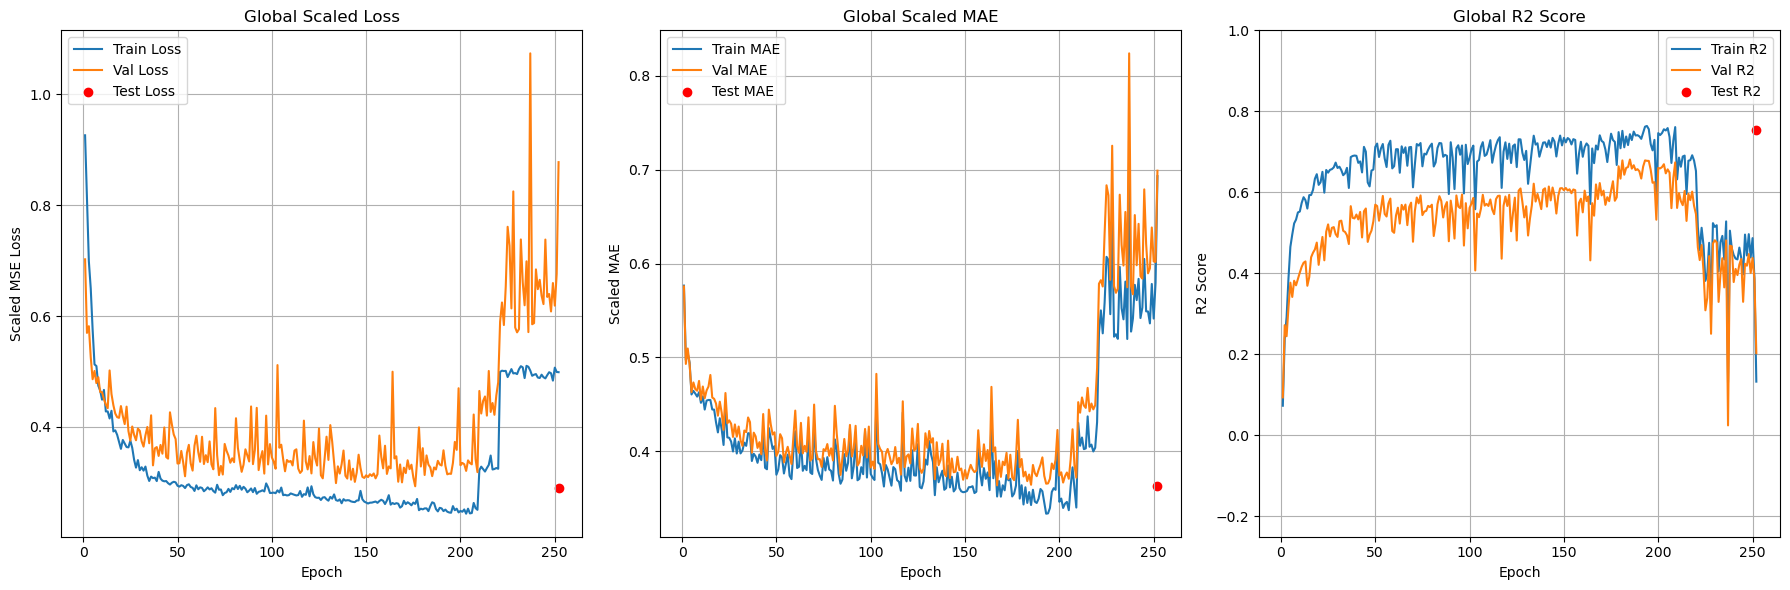

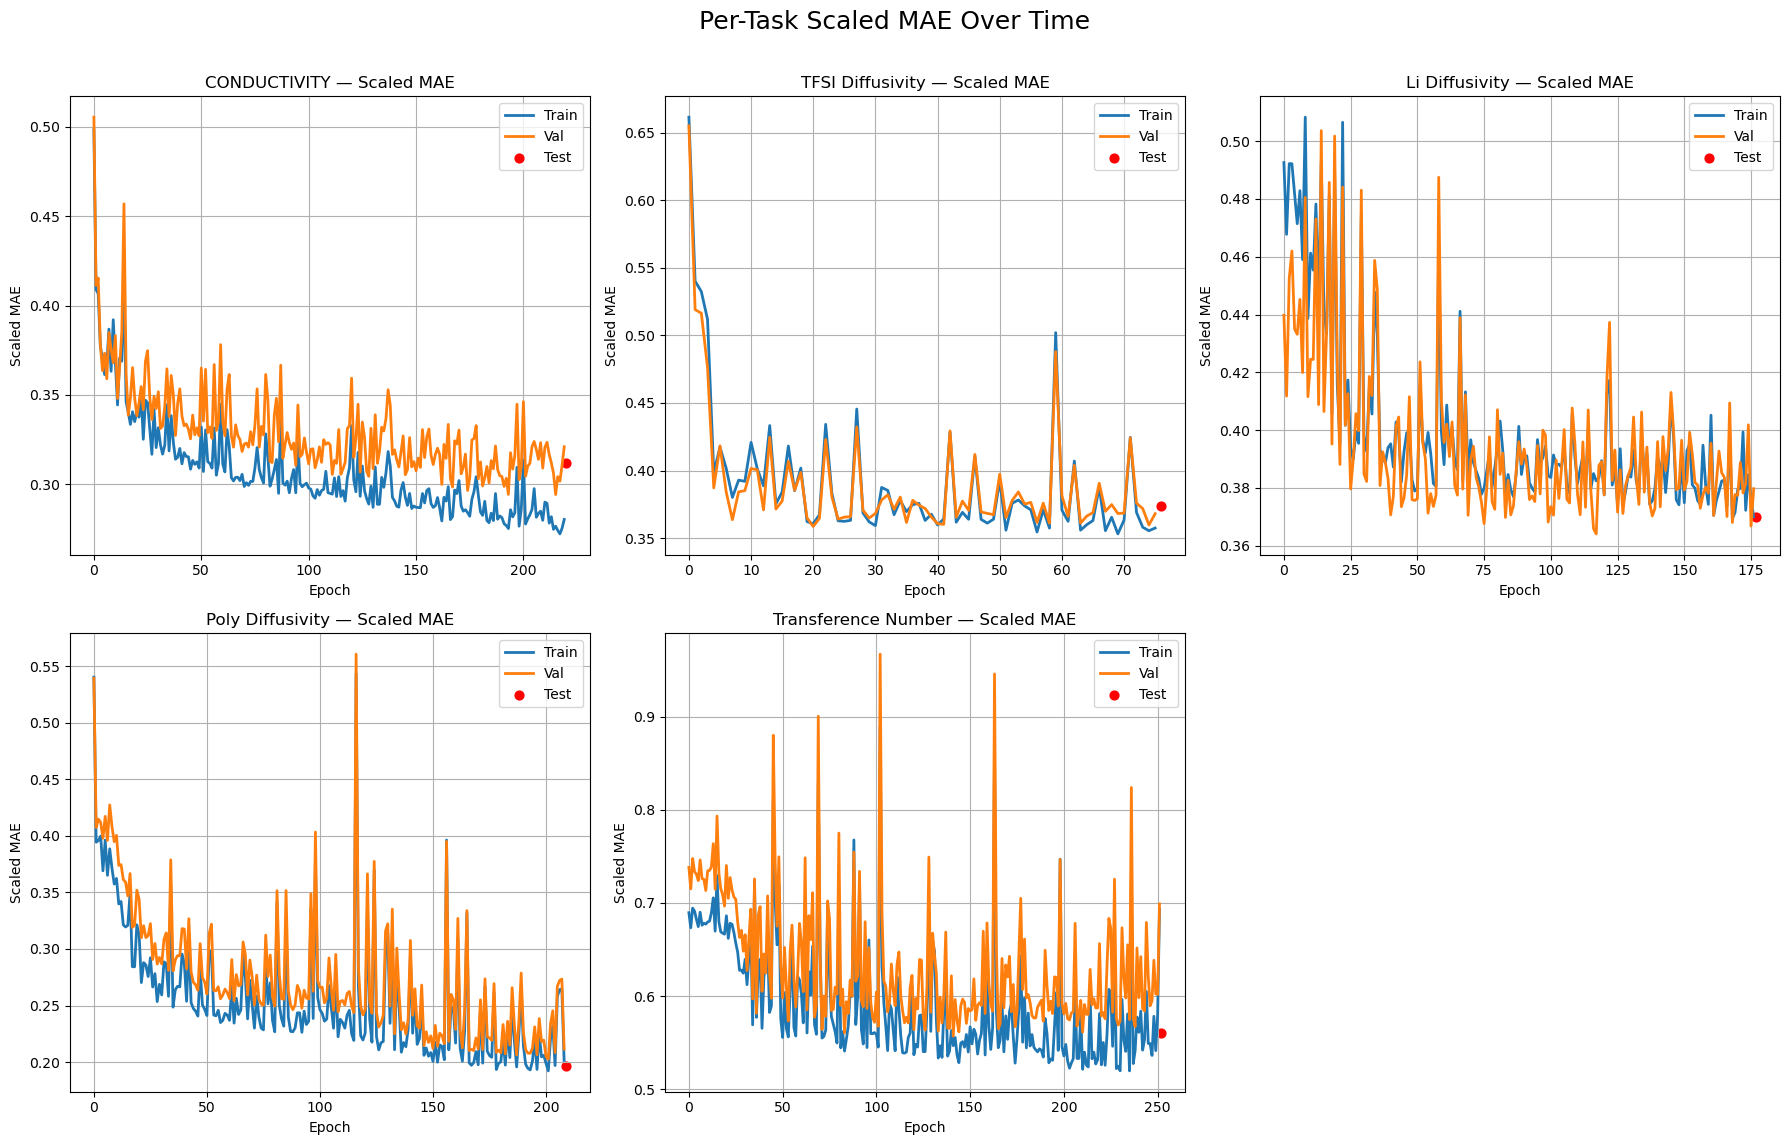

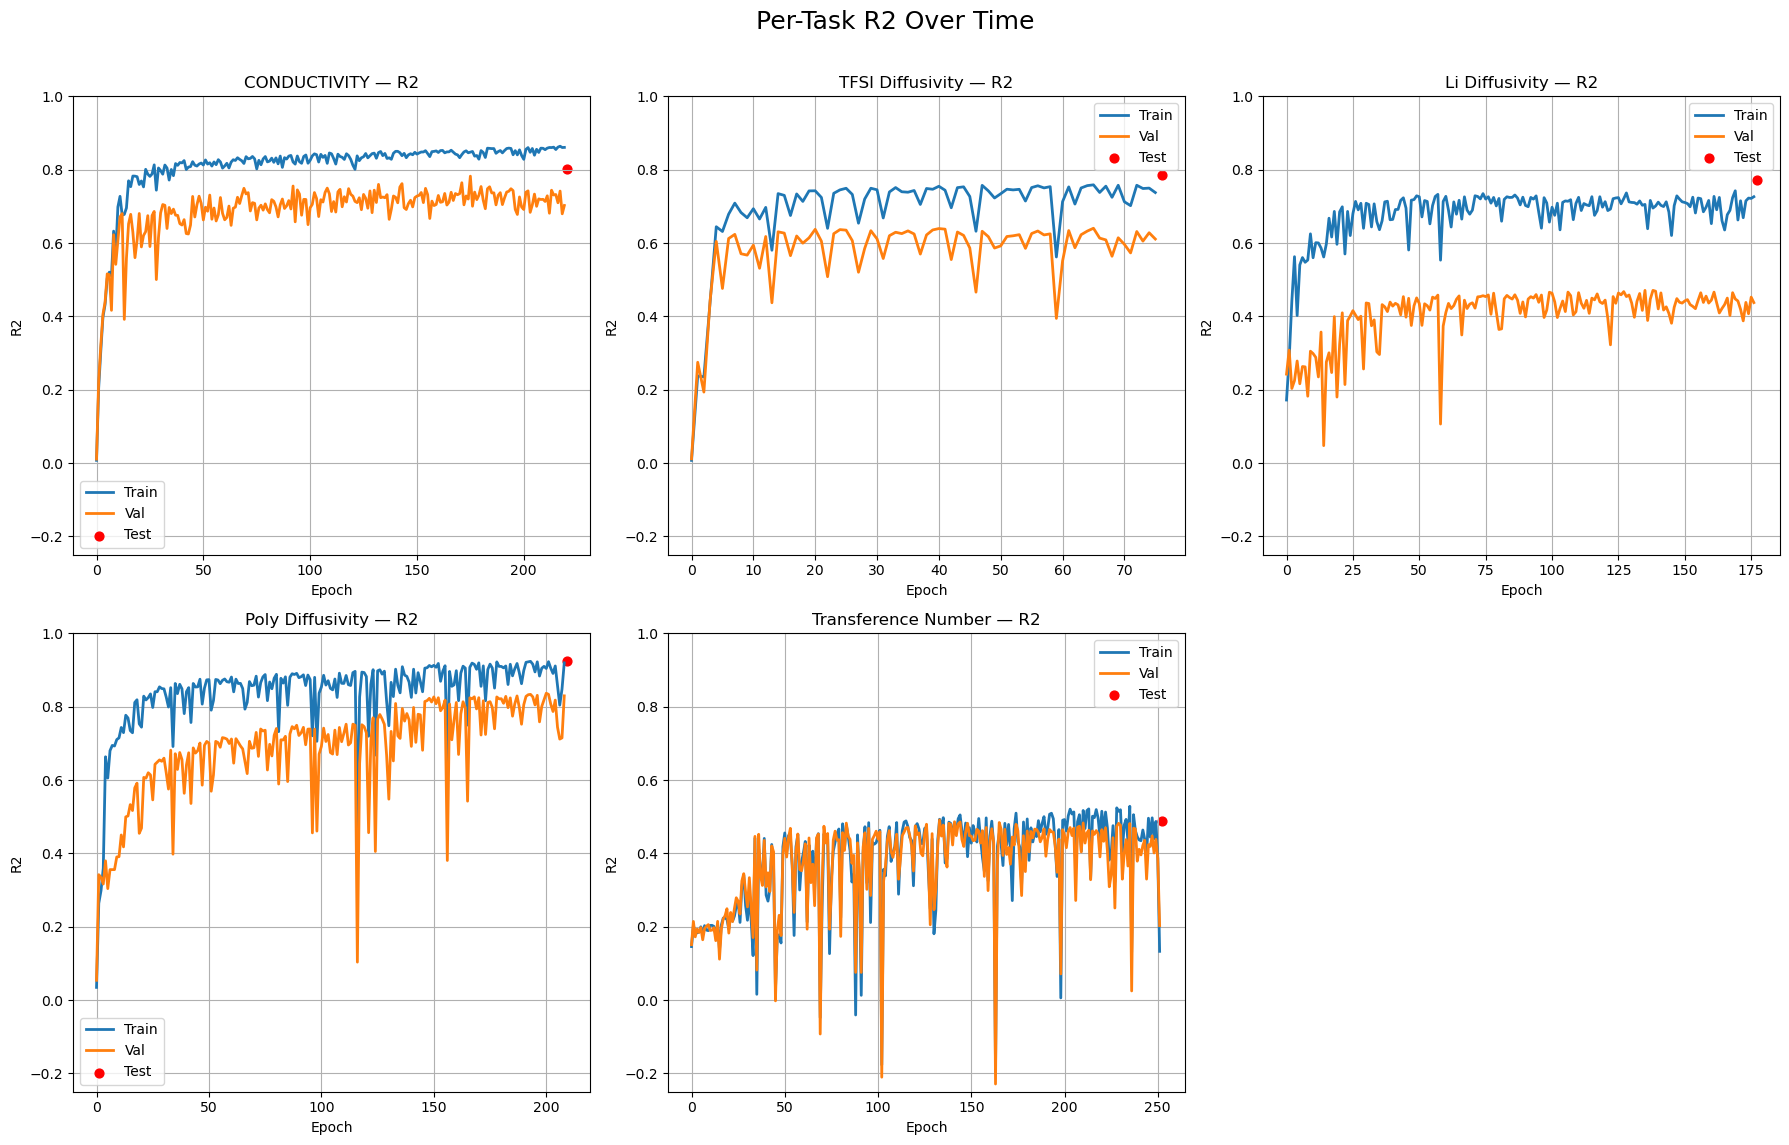

In [44]:
print('Best score (no molecular features):',score_nomol)
plot_all_metrics(final_metrics_nomol_combined, target_cols_labels_full, save_prefix="nomol")

Best score (with molecular features): -0.621081531047821


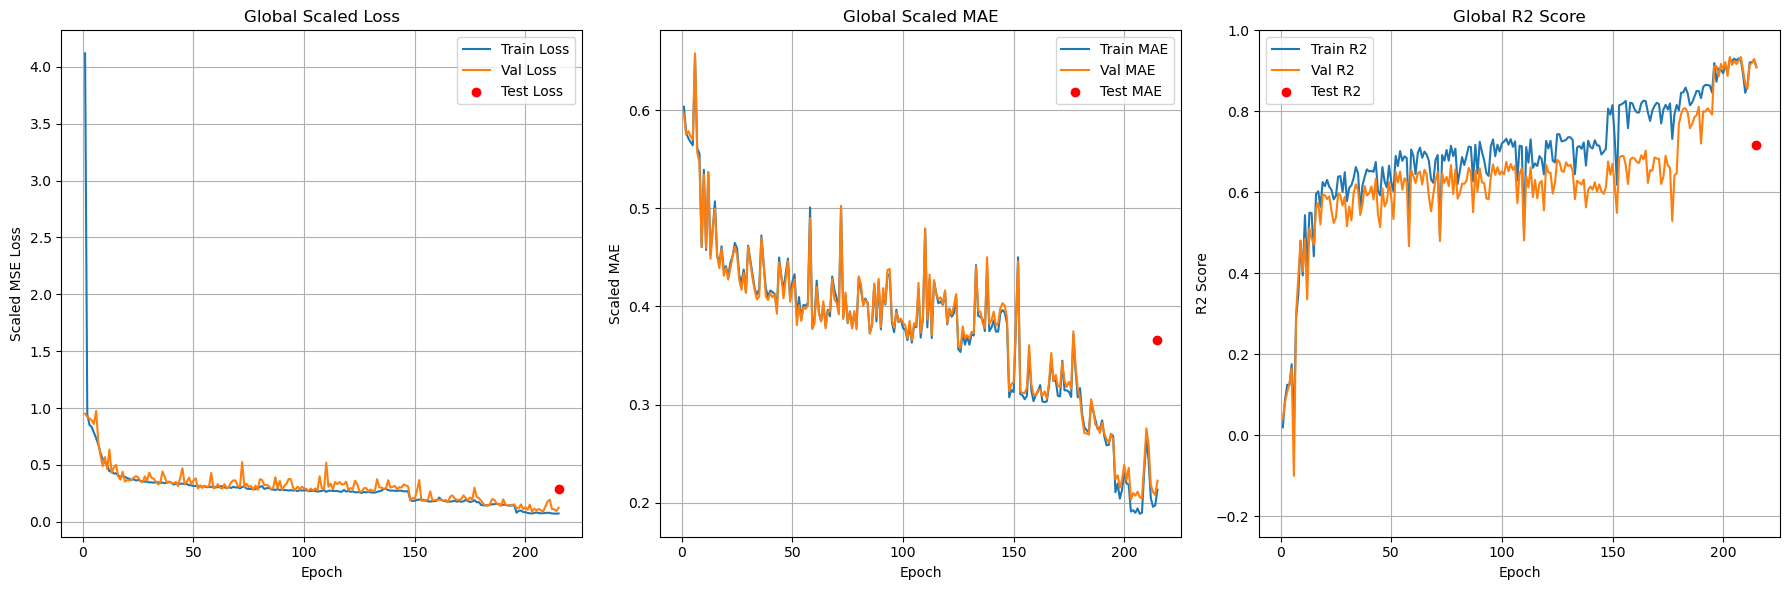

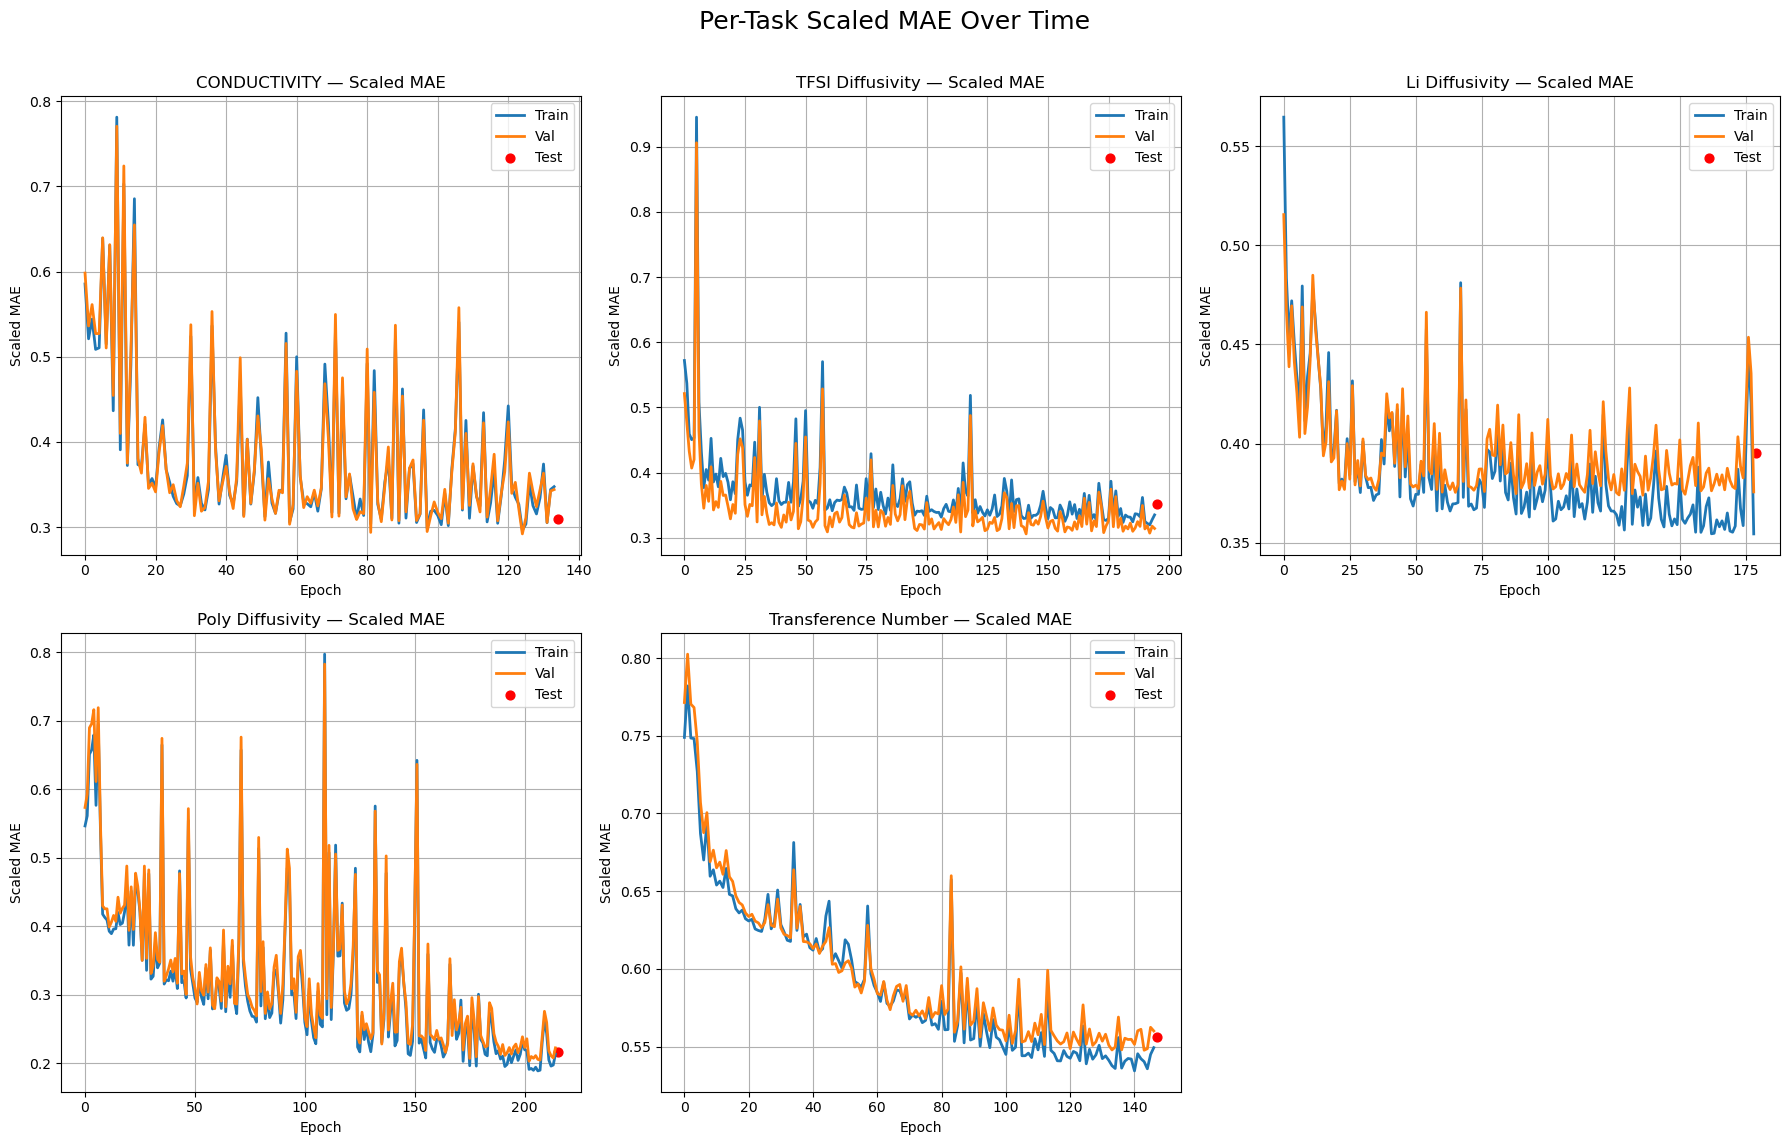

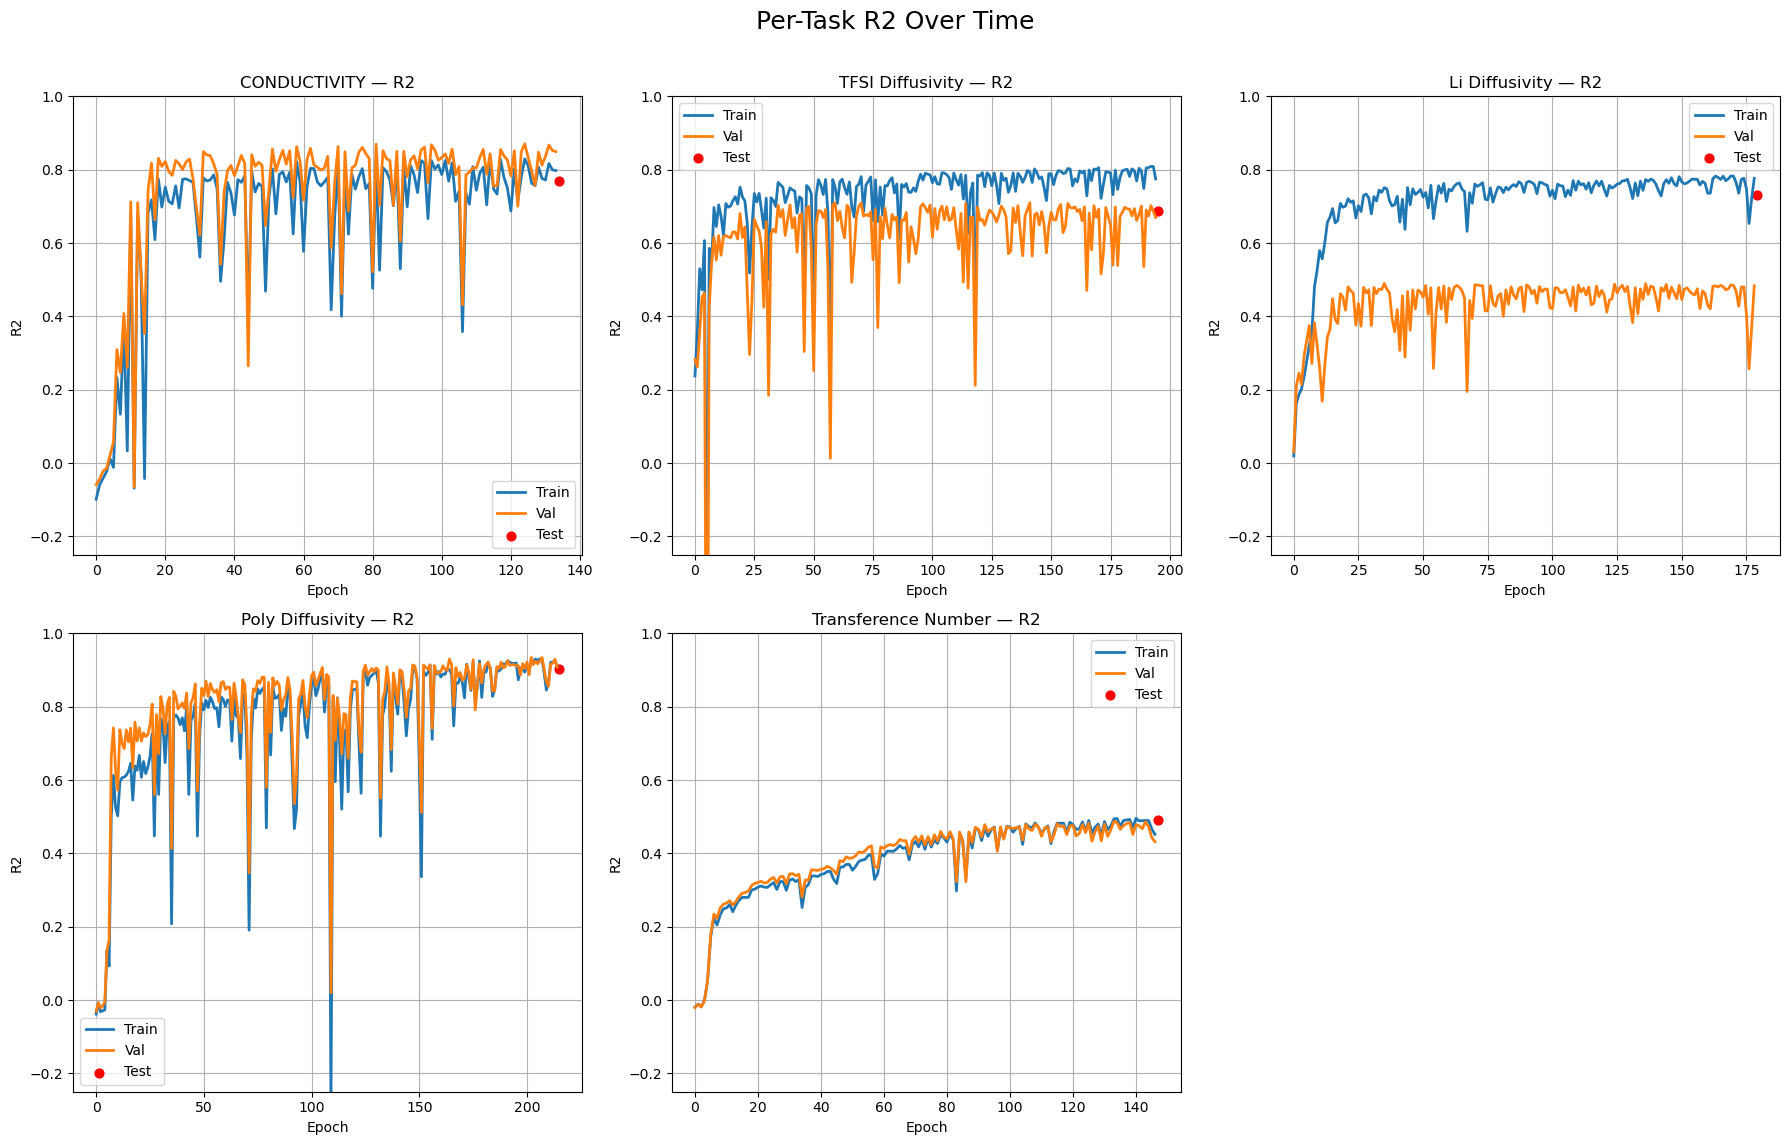

In [41]:
print('Best score (with molecular features):',score_withmol)
plot_all_metrics(final_metrics_withmol_combined, target_cols_labels_full, save_prefix="withmol")

In [42]:
print({key: float(value) for key, value in final_metrics_nomol_combined['test']['per_task_mae'].items()})
print({key: float(value) for key, value in final_metrics_nomol_combined['test']['per_task_r2'].items()})

print({key: float(value) for key, value in final_metrics_withmol_combined['test']['per_task_mae'].items()})
print({key: float(value) for key, value in final_metrics_withmol_combined['test']['per_task_r2'].items()})

{'CONDUCTIVITY': 0.3120531439781189, 'TFSI Diffusivity': 0.37402328848838806, 'Li Diffusivity': 0.3699299395084381, 'Poly Diffusivity': 0.19657006859779358, 'Transference Number': 0.5605029463768005}
{'CONDUCTIVITY': 0.801993191242218, 'TFSI Diffusivity': 0.7841832637786865, 'Li Diffusivity': 0.7712626457214355, 'Poly Diffusivity': 0.92332923412323, 'Transference Number': 0.4871968626976013}
{'CONDUCTIVITY': 0.30963122844696045, 'TFSI Diffusivity': 0.35104817152023315, 'Li Diffusivity': 0.39513665437698364, 'Poly Diffusivity': 0.21586474776268005, 'Transference Number': 0.5559934973716736}
{'CONDUCTIVITY': 0.7696875929832458, 'TFSI Diffusivity': 0.6880184412002563, 'Li Diffusivity': 0.7305302619934082, 'Poly Diffusivity': 0.9033066034317017, 'Transference Number': 0.4909054636955261}


In [43]:
for k in target_cols_labels_full:
    temp_k = k.replace(" ","")
    torch.save(final_model_nomol[k],f'./model_out/optimal_model_nomol_{temp_k}.pth')
    with open(f"./model_out/optimal_model_nomol_params_{temp_k}.txt", "w") as file:
        for k, v in best_params_nomol.items():
            file.write(f"{k}: {v}\n")

    torch.save(final_model_withmol[k],f'./model_out/optimal_model_withmol_{temp_k}.pth')
    with open(f"./model_out/optimal_model_withmol_params_{temp_k}.txt", "w") as file:
        for k, v in best_params_withmol.items():
            file.write(f"{k}: {v}\n")